In [1]:
# imports and loadings
import os
import sys
sys.path.insert(0, '../functions/')
import create_data_for_single_gene as cdg
import interface_GAMS as iG
import parameter_optimization as po
import conversion_equations as ce
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib.colors import Normalize
import mplcursors  # Import mplcursors library
import numpy as np
import pickle
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
import ast
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# settings
#genes = ['b3255', 'b2323', 'b1092', 'b1288', 'b0185', 'b3256', 'b0954', 'b1093', 'b1091', 'b2316']
genes = ['b3255', 'b1288', 'b0185', 'b3256', 'b2316']
case = 'fadR'
pull_best_paras = False # pull best results from parameter_optimization, else use defaults

###### notes ######
# argR genes = ['b2818', 'b3959', 'b3958', 'b3359', 'b3957', 'b0273', 'b3172', 'b3960', 'b4254']
# fadR genes = ['b3255', 'b2323', 'b1092', 'b1288', 'b0185', 'b3256', 'b0954', 'b1093', 'b1091', 'b2316']

# setting promoter and inhibitor
if case == 'argR':
    promoter = None
    inhibitor = 'b3237'
elif case == 'fadR':
    promoter = 'b1187'
    inhibitor = None
    
if not os.path.exists('../data/case_to_mRNA_passed.pkl'):
    case_to_mRNA_passed = {}
else:
    pickle_in = open('../data/case_to_mRNA_passed.pkl', 'rb')
    case_to_mRNA_passed = pickle.load(pickle_in)
    pickle_in.close()
    
# below are the default flags used if nothing is pre-set
# set flags by editing the "saved_flags.csv" in the ../data folder
t_half_life_deg = 300
flags = { # add additional settings that should be changed between runs here
    # general flags
    'central_gene' : 'b1819',
    'force_rerun' : True,
    'sanity_plots' : True,
    'act_iM' : 'Crp-1',
    'inh_iM' : 'DhaR/Mlc',
    'basal_conditions' : ['control__wt_glc__1', 'control__wt_glc__2'],
    'grid_use' : -1, # which of the generated constants grids do you want to use? -1 is the highest KdRNAP
    
    # basal model flags
    'basal_bool': False, # If true, use imported values for basal expression

    # mRNA ratios flags
    'basal_or_hard_val' : 'basal', # use basal conditions for ratio or some hard value
    'hard_val' : 10, # the basal log tpm value
    'use_zerod_A_matrix' : True, # recalculate the ICA matrices based on zeroing out gene values in iModulons not of interest

    # picking KdRNAPCrp values
    'initial_guess_ratio' : .3, # this commonly needs to get raised and lowered to get a good value, eventually I will figure out a way to automate it if this step stays in the pipeline
    'use_target_range' : False, # if True, adds a model parameter that encourages the cActivator range to match (cInhibitor is not affected by KdRNAPCrp and can't be adjusted for here)
    'target_range' : [-1, 3],
    'base_cInhibitor_val' : 0.2, # this is the set minimum value to solve cActivator based on to set its dynamic range
    'base_cActivator_val' : 0.2, # defines the range of cInhibitor values available
    
    # cAct & cInh Grid flags
    'auto_set_max_range' : True, # if True, set the range based on the set to zero values of the KdRNAPCrp calculator
    'additional_tolerance' : 0.2, # add this %age of the maximum to the top
    'cActivator' : [-4,2], # Uses a log10 range
    'cInhibitor': [-4,2], # Uses a log10 range
    'run_greedy' : True, # skips greedy algo to save time

    # GA - best cActivator/cInhibitor flags
    'neg_grid_toss_OR_zero' : 'toss', # options: toss or zero, what to do with negative grid values
    'seed' : 42,
    'n_ind' : 100, # Starting population size
    'mu' : 100, # Number of individuals to select for the next generation
    'lambda_' : 100, # Number of offspring to produce
    'cxpb' : 0.6, # Chance of crossover
    'cx_prob' : 0.6, # Chance that a condition is crossed
    'mutpb' : 0.4, # Chance an individual undergoes mutation
    'mt_prob' : 0.1, # Chance that a condition in individual is mutated
    'n_gen' : 100, # Number of generations
    'verbose' : False, # Show the logbook as GA runs
    # NOTE: To modify the selection algorithm, modify the toolbox in the GA section of the notebook
    
    # greedy
    'n_iter' : 5, # Number of greedy individuals to produce, takes ~1 min for each
    'max_steps' : 30, # Maximum number of steps before moving on to next condition
    'n_rounds' : 100, # Number of loops of the shuffled conditions with the max steps for each greedy individual
}
flags_df = pd.read_csv('../data/saved_flags.csv', index_col = 0)
TF_flags_df = pd.read_csv('../data/TF_saved_flags.csv', index_col = 0)
stable_flags = { # these do not change gene by gene
    # overall
    'run_basal_calculations' : True, # it is very slow and should only be necessary to run if something has changed basal conditions
    'only_create_ratios' : False,
    'only_check_KdRNAPCrp' : False, # if True, quit out of code after generating KdRNAPCrp, done to see if it is generating valid values through sanity check plots
    'save_results' : True, # saves resulting figures and cAct/cInh values of the previous run to the save_results_run folder
    'include_Amy_samples' : True, # append on Amy's stationary phase samples to analysis
    'remove_outliers' : True, # removes samples that do not correlate well with others, see ../data_cleaning/1_locate_outliers_to_drop.ipynb
    'case' : case, # only used for remove_outliers right now
    'drop_basal_conds' : True, # if True, removes basal conditions from sample after they're used to calculate ratios (useful when their outliers)
    
    # KdRNAPCrp optimization
    'KdRNAPCrp_sanity' : True, # if True, return sanity plots from this optimization
    
    # GAMs
    'limit_TF_conc_by_actual' : False, # limits the TF concentrations for the model by the actual values, otherwise lets it be a very wide range
    'supress_output' : False,
    'use_greedy' : True, # use the greedy algo values (if False, uses the results of the GA)
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : genes, # if run_on_all is False, limit to these samples (or which of them are available)
    'delete_old' : True,
    'run_seperate' : False, # run cActivator and cInhibitor solvers seperately
    
    # input constants for GAMs (all get logged inside GAMs so pass in un-logged)
    'act_TF_conc_lo' : 2.902870141566294e-13 / 1000, # minimum TF conc found in Heineman data
    'act_TF_conc_up' : 0.00014190659526601638 * 1000, # max of ^
    'act_Kd_lo' : 11e-9 / 1000, # 11 - 35 nM (1e-9) is the answer here - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4646316/
    'act_Kd_up' : 35e-9 * 1000, # from above
    'inh_TF_conc_lo' : 2.902870141566294e-13 / 1000, # minimum TF conc found in Heineman data
    'inh_TF_conc_up' : 0.00014190659526601638 * 1000, # max of ^
    'inh_Kd_lo' : 11e-9 / 1000, # 11 - 35 nM (1e-9) is the answer here - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4646316/
    'inh_Kd_up' : 35e-9 * 1000, # from above
    'metab_Total_lo' : 0.000038 / 1000, # minimum of arginine concentration in stationary phase samples, div a buffer
    'metab_Total_up' : 0.000408 * 1000, # maximum of arginine concentration in stationary phase samples, mult a buffer
    
    # best for argR
    #'act_TF_conc_lo' : 2.902870141566294e-13 / 100, # minimum TF conc found in Heineman data
    #'act_TF_conc_up' : 0.00014190659526601638 * 100, # max of ^
    #'act_Kd_lo' : 11e-9 / 100, # 11 - 35 nM (1e-9) is the answer here - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4646316/
    #'act_Kd_up' : 35e-9 * 100, # from above
    #'inh_TF_conc_lo' : 2.902870141566294e-13 / 100, # minimum TF conc found in Heineman data
    #'inh_TF_conc_up' : 0.00014190659526601638 * 100, # max of ^
    #'inh_Kd_lo' : 11e-9 / 100, # 11 - 35 nM (1e-9) is the answer here - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4646316/
    #'inh_Kd_up' : 35e-9 * 100, # from above
    #'metab_Total_lo' : 0.000038 / 100, # minimum of arginine concentration in stationary phase samples, div a buffer
    #'metab_Total_up' : 0.000408 * 100, # maximum of arginine concentration in stationary phase samples, mult a buffer
    
    
    # objective function weightings
    'weight_act_obj1' : 1,
    'weight_inh_obj1' : 1,
    'weight_act_obj2' : 0,
    'weight_inh_obj2' : 0,
    'weight_mRNA_match' : 0.0001,
    'weight_act_corr' : 0.00000000000000001,
    'weight_inh_corr' : 0.00000000000000001,
    
    
    # misc
    'eq_str' : 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
            KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
            cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
            KeqOpening)*RNAP))',
    
    # cell_constants'
    'cell_constants_RNAP': 10**-6,
    'cell_constants_mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_constants_cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
    'cell_constants_kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'cell_constants_promoterConcVal': 10**-9, # Promoter concentration
    'cell_constants_u': 1/3600, # Growth rate
}

# pick best parameters from the optimization results
if pull_best_paras:
    pickle_in = open('../data/case_to_best_paras.pkl', 'rb')
    case_to_best_paras = pickle.load(pickle_in)
    pickle_in.close()
    paras_df = case_to_best_paras[case+'_case']
    paras = [
        'act_TF_conc_lo', 'act_TF_conc_up', 
        'inh_TF_conc_lo', 'inh_TF_conc_up', 
        'inh_Kd_lo', 'inh_Kd_up', 
        'inh_metab_Total_lo', 'inh_metab_Total_up', 
        'act_metab_Total_lo', 'act_metab_Total_up', 
        'weight_act_obj1', 'weight_inh_obj1', 
        'weight_act_obj2', 'weight_inh_obj2', 
        'weight_mRNA_match', 'weight_act_corr', 
        'weight_inh_corr'
    ]
    for para in paras:
        if para in paras_df.index:
            stable_flags.update({para : paras_df.loc[para].values[0]})
    for key in ['act_TF_conc_lo', 'act_TF_conc_up' 'act_Kd_lo', 'act_Kd_up', 'inh_TF_conc_lo', 'inh_TF_conc_up', 'inh_Kd_lo', 'inh_Kd_up', 'weight_act_obj1', 'weight_inh_obj1', 'weight_act_obj2', 'weight_inh_obj2', 'weight_mRNA_match', 'weight_act_corr', 'weight_inh_corr']:
        if key in paras_df.index:
            stable_flags.update({key : paras_df.loc[key].values[0]})

def show_figure(fig):

    # create a dummy figure and use its
    # manager to display "fig"

    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)

In [2]:
# multiprocess run

# overall setup
if stable_flags['save_results']:
    folders = [val for val in os.listdir('../data/saved_run_results') if 'run' in val]
    if len(folders) == 0:
        run_ct = 1
    else:
        run_ct = max([int(val.split('_')[1]) for val in folders]) + 1
    new_run_folder = '../data/saved_run_results/run_'+str(run_ct)
    os.mkdir(new_run_folder)
    
    # put the flags df in there
    flags_df.to_csv(new_run_folder+'/saved_flags.csv')
# setup inputs
gene_flags = []

for gene in genes:
    temp_flags = dict(flags_df.loc[gene])
    temp_flags.update({'central_gene' : gene})
    
    # need to convert some flags from strings to lists
    for col in ['basal_conditions', 'target_range', 'cActivator', 'cInhibitor']:
        temp_flags[col] = ast.literal_eval(temp_flags[col])
    
    # convert cell constants into a dictionary
    temp_flags.update({'cell_constants' : {
        'RNAP' : stable_flags['cell_constants_RNAP'],
        'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
        'cell_volume' : stable_flags['cell_constants_cell_volume'],
        'kDeg' : stable_flags['cell_constants_kDeg'],
        'promoterConcVal' : stable_flags['cell_constants_promoterConcVal'],
        'u' : stable_flags['cell_constants_u'],
        'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
    }})
    temp_flags.update({'run_basal_calculations' : stable_flags['run_basal_calculations']})
    temp_flags.update({'eq_str' : stable_flags['eq_str']})
    temp_flags.update({'save_results' : stable_flags['save_results']})
    temp_flags.update({'save_results_folder' : new_run_folder})
    temp_flags.update({'include_Amy_samples' : stable_flags['include_Amy_samples']})
    temp_flags.update({'only_check_KdRNAPCrp' : stable_flags['only_check_KdRNAPCrp']})
    temp_flags.update({'only_create_ratios' : stable_flags['only_create_ratios']})
    temp_flags.update({'KdRNAPCrp_sanity' : stable_flags['KdRNAPCrp_sanity']})
    temp_flags.update({'remove_outliers' : stable_flags['remove_outliers']})
    temp_flags.update({'case' : stable_flags['case']})
    temp_flags.update({'drop_basal_conds' : stable_flags['drop_basal_conds']})
    
    gene_flags.append(temp_flags)

# run pool
pool = multiprocessing.Pool(processes = 8)
results = pool.map(cdg.create_data_for_gene, gene_flags)
pool.close()
pool.join()

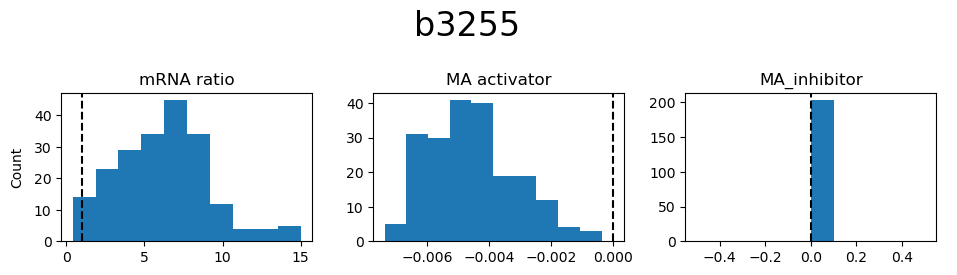

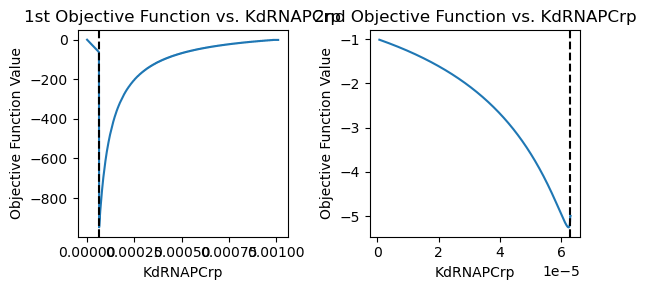

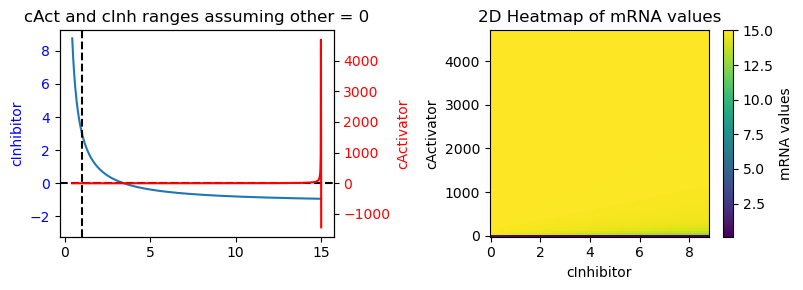

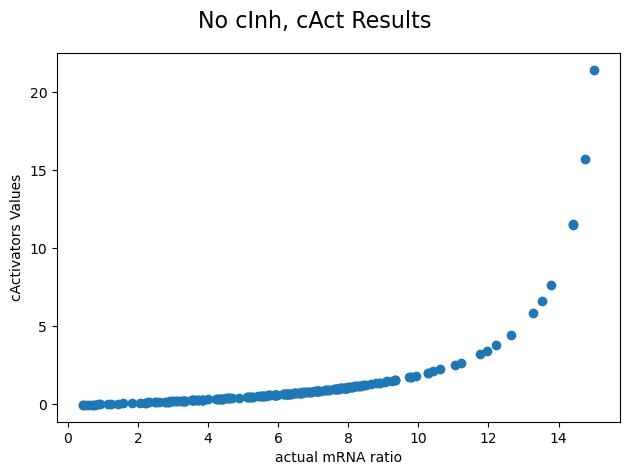

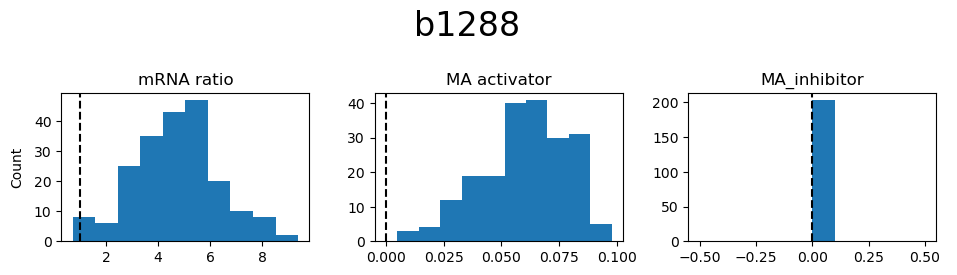

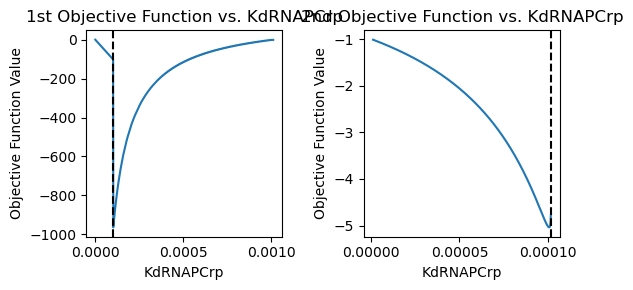

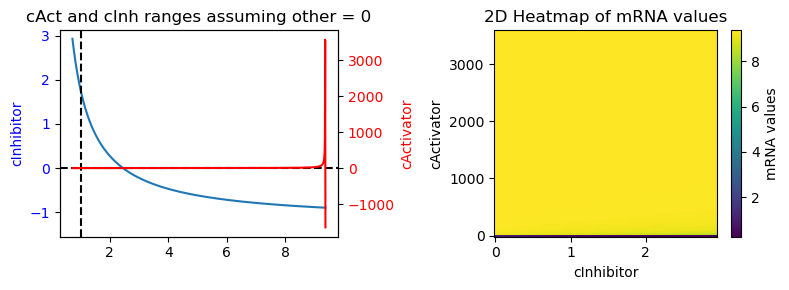

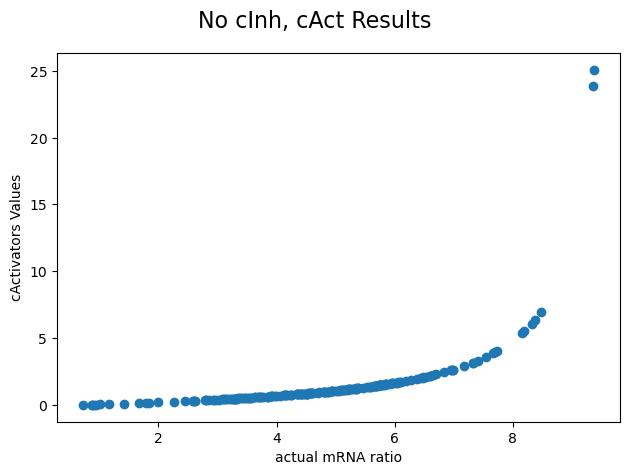

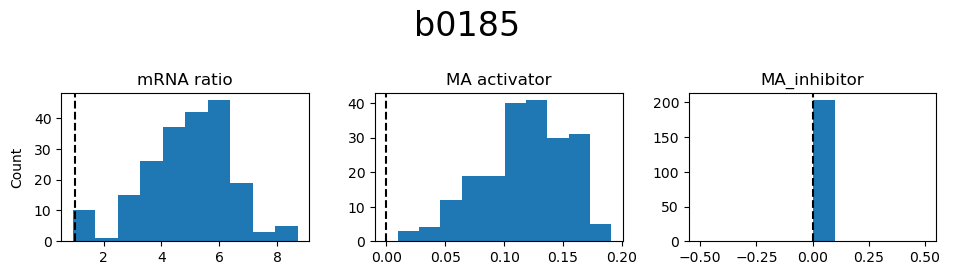

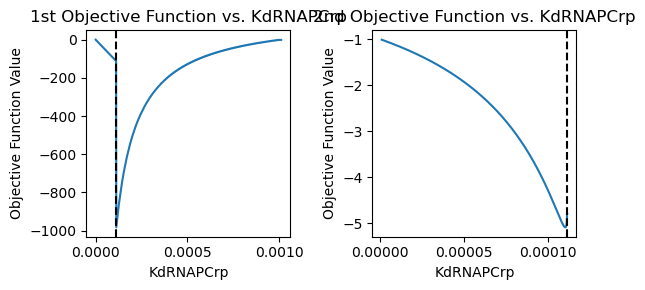

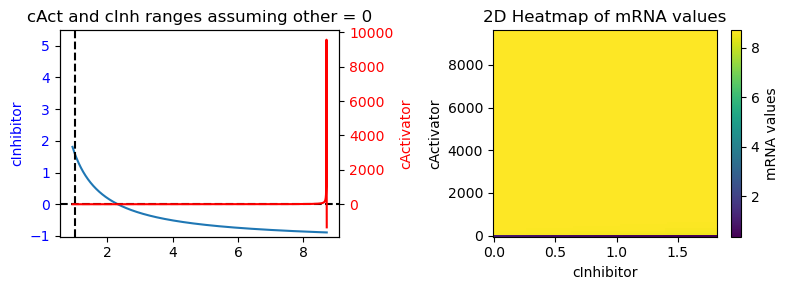

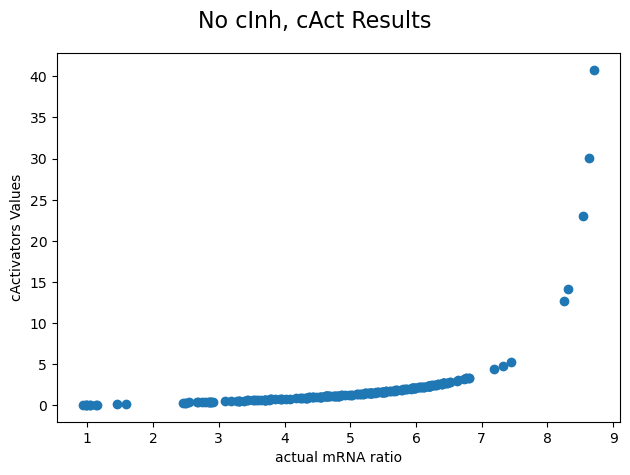

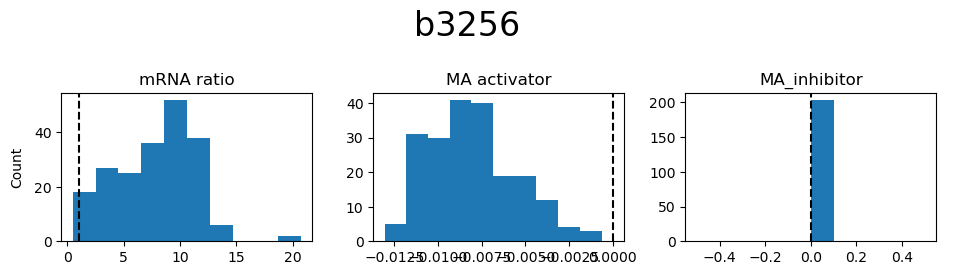

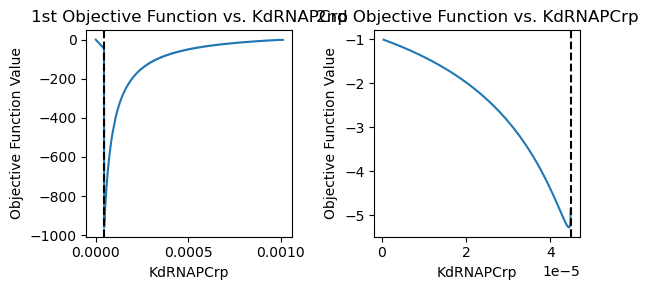

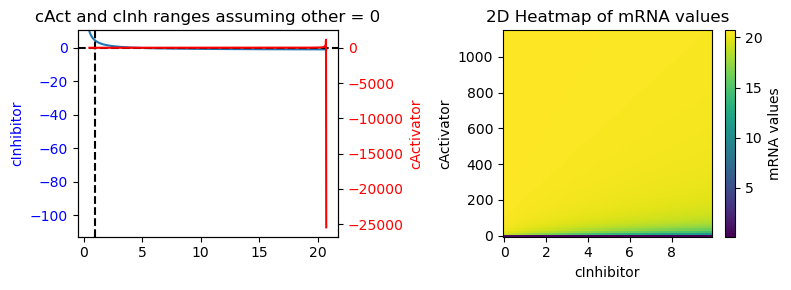

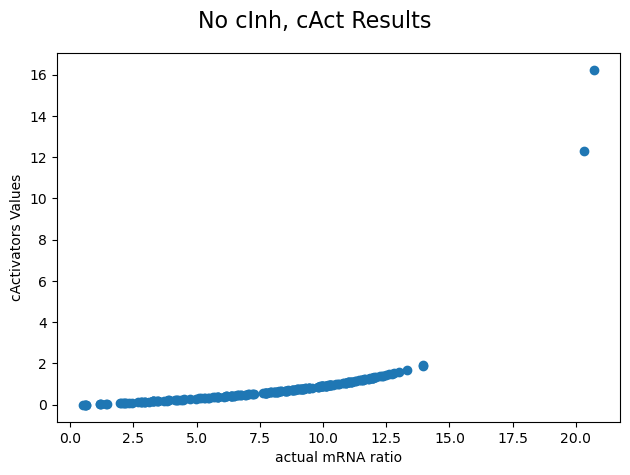

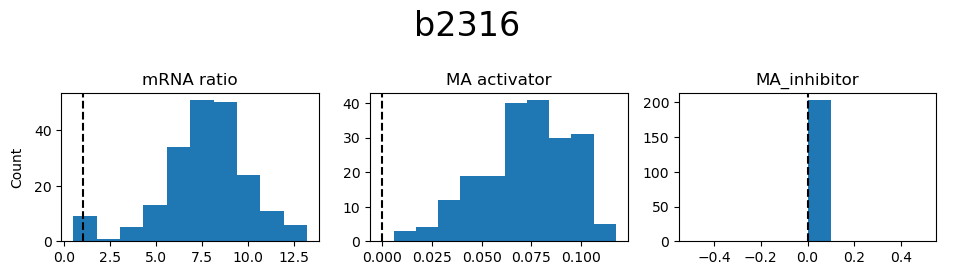

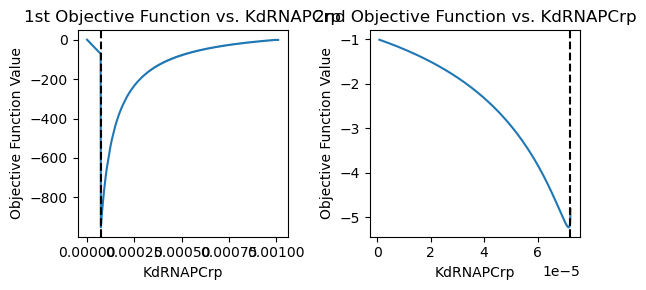

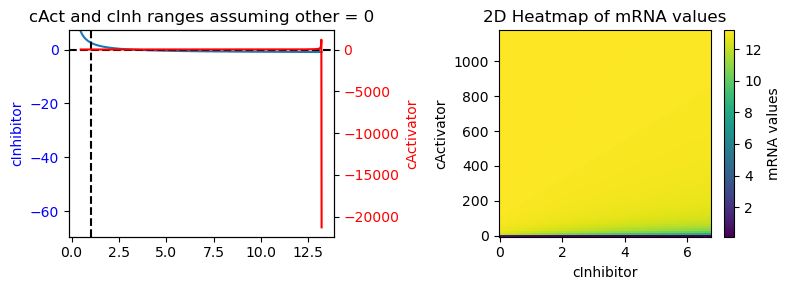

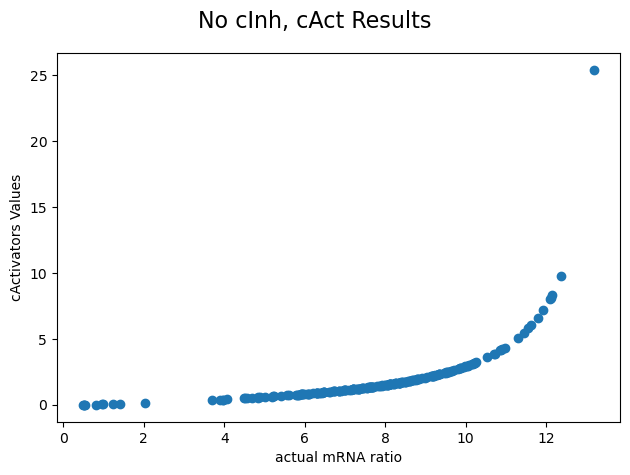

In [3]:
# display gene specific results
# display an overall plot first
if False: # this figure only works correclty in some cases, remove for now
    fig = plt.figure(figsize = (3, 3))
    for gene in genes:
        file = gene+'_zerod'+str(flags['use_zerod_A_matrix'])+'_cAct_cInh_vals.csv'
        vals_df = pd.read_csv('../data/save_for_GAMs/'+file, index_col = 0)
        plt.scatter(vals_df['cAct'], vals_df['cInh'], label = gene, alpha = 0.3)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('cActivator')
    plt.ylabel('cInhibitor')
    plt.legend()
    plt.title('All cActivator and cInhibitor Values')
    plt.show()

folders = [val for val in os.listdir('../data/saved_run_results') if 'run' in val]
if len(folders) == 0:
    run_ct = 1
else:
    run_ct = max([int(val.split('_')[1]) for val in folders])
new_run_folder = '../data/saved_run_results/run_'+str(run_ct)
    
# display gene specific plot
if stable_flags['save_results']:
    results = []
    for gene in genes:
        pickle_in = open(new_run_folder+'/'+gene+'/figures.pkl', 'rb')
        results.append(pickle.load(pickle_in))
        pickle_in.close()
for gene, result in zip(genes, results):
    result[0].suptitle(gene, fontsize = 24)
    result[0].tight_layout()
    for res in result:
        show_figure(res)
        #display(plt.gcf())

In [4]:
# run GAMs
# below taken from 1_GAMs_parameter_optimization
best_paras = None#{'act_TF_conc_lo': 1e-11, 'act_TF_conc_up': 1e-05, 'act_Kd_lo': 1e-11, 'act_Kd_up': 1e-06, 'inh_TF_conc_lo': 1e-11, 'inh_TF_conc_up': 1e-05, 'inh_Kd_lo': 1e-11, 'inh_Kd_up': 1e-06, 'weight_act_obj1': 0.1, 'weight_inh_obj1': 0.1, 'weight_act_obj2': 0.0, 'weight_inh_obj2': 0.0, 'weight_mRNA_match': 0.055, 'weight_act_corr': 1e-17, 'weight_inh_corr': 1e-17}

    
if flags['force_rerun']:
    cell_constants = {}
    cell_constants.update({
        'RNAP' : stable_flags['cell_constants_RNAP'],
        'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
        'cell_volume' : stable_flags['cell_constants_cell_volume'],
        'kDeg' : stable_flags['cell_constants_kDeg'],
        'promoterConcVal' : stable_flags['cell_constants_promoterConcVal'],
    })
    run_vals = [-1]
    for f in os.listdir('../GAMs/runs/'):
        if 'run_' in f: run_vals.append(int(f.split('_')[1]))
    GAMs_run_dir = '../GAMs/runs/run_'+str(max(run_vals)+1)
    os.mkdir(GAMs_run_dir)
    os.mkdir(GAMs_run_dir+'/input_files')
    os.mkdir(GAMs_run_dir+'/output_files')
    os.mkdir(GAMs_run_dir+'/input_GDX')
    os.mkdir(GAMs_run_dir+'/output_GDX')
    
    if stable_flags['limit_TF_conc_by_actual']:
        conc_df = pd.read_csv('../data/validation_data_sets/converted_log_tpm_in_M.csv', index_col = 0)
        if inhibitor:
            stable_flags.update({
                # input constants for GAMs (all get logged inside GAMs so pass in un-logged)
                'inh_TF_conc_lo' : min(conc_df.loc[inhibitor])/1.5, # give extra room on both sides
                'inh_TF_conc_up' : max(conc_df.loc[inhibitor])*1.5,
                # give some extra room on the Kd parameters
                'inh_Kd_lo': stable_flags['inh_Kd_lo'] / 1000,
                'inh_Kd_up': stable_flags['inh_Kd_up'] * 1000,
            })
        if promoter:
            stable_flags.update({
                # input constants for GAMs (all get logged inside GAMs so pass in un-logged)
                'act_TF_conc_lo' : min(conc_df.loc[promoter])/1.5, # give extra room on both sides
                'act_TF_conc_up' : max(conc_df.loc[promoter])*1.5,
                # give some extra room on the Kd parameters
                'act_Kd_lo': stable_flags['act_Kd_lo'] / 1000,
                'act_Kd_up': stable_flags['act_Kd_up'] * 1000,
            })
    # 'b3357', 'b1594' for crp, mlc
    print('Running at '+GAMs_run_dir)
    iG.run_GAMs(flags_df, TF_flags_df, stable_flags, promoter, inhibitor, cell_constants, GAMs_run_dir, parameter_flags = best_paras)

Running at ../GAMs/runs/run_11


C:\Users\SBRG_2024\AppData\Local\Temp\ipykernel_12248\3242998746.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')
C:\Users\SBRG_2024\AppData\Local\Temp\ipykernel_12248\3242998746.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')
C:\Users\SBRG_2024\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


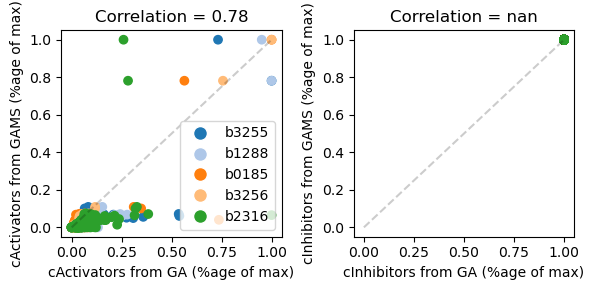

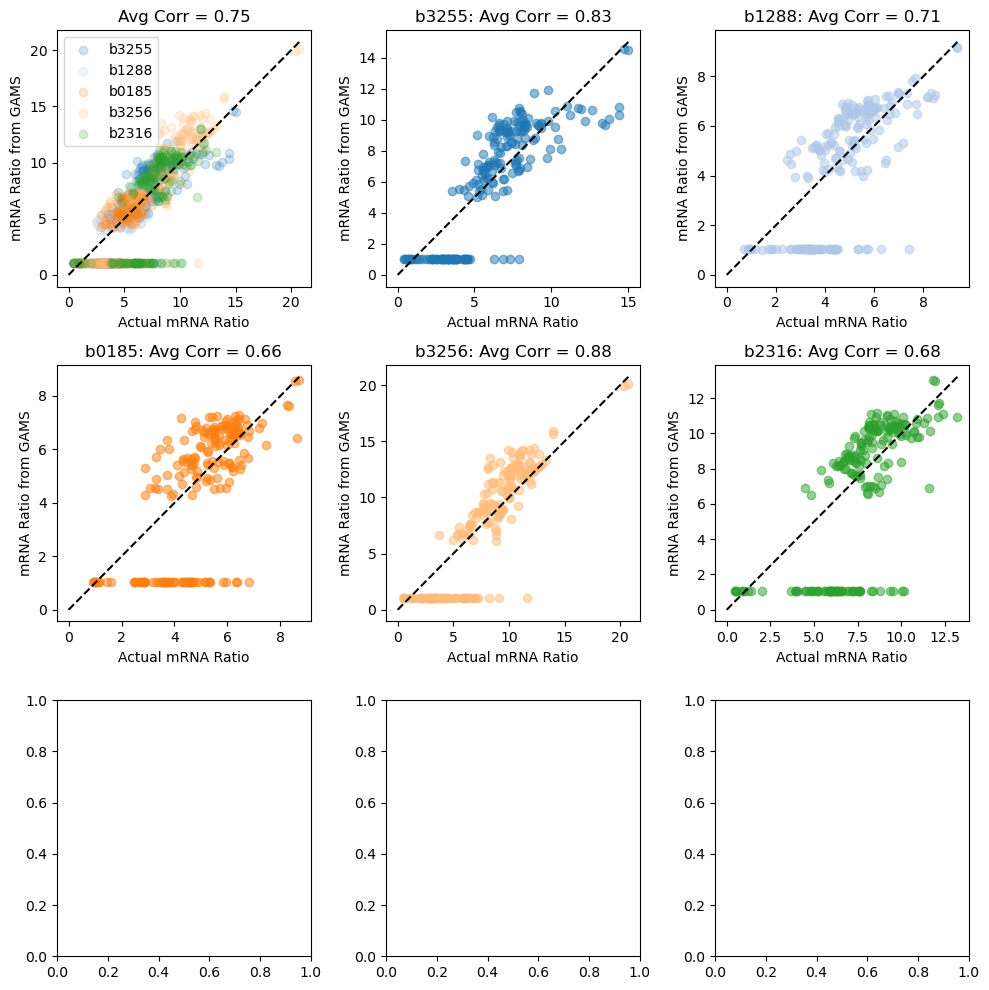

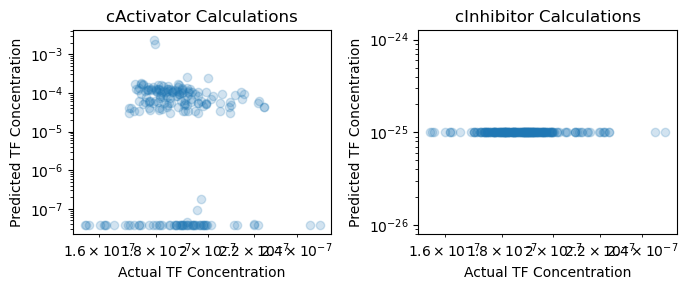

In [5]:
# read and display GAMs
clustering = False
run_vals = [int(f.split('_')[1]) for f in os.listdir('../GAMs/runs/') if 'run_' in f]
GAMs_run_dir = '../GAMs/runs/run_'+str(max(run_vals))
calc_cAct, cAct_kd_df, cAct_TF_conc_df, calc_cInh, cInh_kd_df, cInh_TF_conc_df = iG.read_GAMs(GAMs_run_dir)
if flags['sanity_plots']:
    # look at GAMs results
    scale_to_100_perc = True # scale cAct / cInh by 100%

    # load in cActivators
    saved_cActivators = pd.read_csv(GAMs_run_dir+'/input_files/composite_cAct_vals.csv', index_col = 0)

    # plotting
    saved = []
    calc = []
    labels = []
    gene_to_color = {}
    cmap = cm.get_cmap('tab20')
    color_opts = iter(cmap.colors)
    colors = []
    for gene in calc_cAct.columns:
        if gene not in gene_to_color:
            gene_to_color.update({gene : next(color_opts)})
        color = gene_to_color[gene]
        for sample in calc_cAct.index:
            if scale_to_100_perc:
                saved.append(saved_cActivators.loc[sample][gene] / max(saved_cActivators[gene]))
                calc.append(calc_cAct.loc[sample][gene] / max(calc_cAct[gene]))
            else:
                saved.append(saved_cActivators.loc[sample][gene])
                calc.append(calc_cAct.loc[sample][gene])
            labels.append(gene+', '+sample)
            colors.append(color)
    fig, axs = plt.subplots(1, 2, figsize = (6, 3))
    scatter = axs[0].scatter(saved, calc, c = colors)
    if scale_to_100_perc:
        axs[0].plot([0, 1], [0, 1], alpha = 0.2, c = 'k', linestyle = '--')
    else:
        axs[0].plot([0, max(saved_cActivators.values.flatten())], [0, max(saved_cActivators.values.flatten())], alpha = 0.2, c = 'k', linestyle = '--')
    if scale_to_100_perc:
        axs[0].set_xlabel('cActivators from GA (%age of max)')
        axs[0].set_ylabel('cActivators from GAMS (%age of max)')
    else:
        axs[0].set_xlabel('cActivators from GA')
        axs[0].set_ylabel('cActivators from GAMS')
    corr = np.corrcoef(saved, calc)
    axs[0].set_title('Correlation = {:.2f}'.format(corr[1][0]))
    #plt.yscale('log')
    #plt.xscale('log')

    # Create an empty list to store legend handles and labels
    legend_elements = []
    for label, color in gene_to_color.items():
        legend_elements.append(plt.Line2D([0], [0], marker = 'o', color = 'w', markersize = 10, markerfacecolor = color, label = label))
    axs[0].legend(handles = legend_elements, loc = 'lower right')


    # now plot cInhibitor
    # load in cActivators
    saved_cActivators = pd.read_csv(GAMs_run_dir+'/input_files/composite_cInh_vals.csv', index_col = 0)

    # plotting
    saved = []
    calc = []
    labels = []
    gene_to_color = {}
    cmap = cm.get_cmap('tab20')
    color_opts = iter(cmap.colors)
    colors = []
    for gene in calc_cInh.columns:
        if gene not in gene_to_color:
            gene_to_color.update({gene : next(color_opts)})
        color = gene_to_color[gene]
        for sample in calc_cInh.index:
            if scale_to_100_perc:
                saved.append(saved_cActivators.loc[sample][gene] / max(saved_cActivators[gene]))
                calc.append(calc_cInh.loc[sample][gene] / max(calc_cInh[gene]))
            else:
                saved.append(saved_cActivators.loc[sample][gene])
                calc.append(calc_cInh.loc[sample][gene])
            labels.append(gene+', '+sample)
            colors.append(color)
    scatter = axs[1].scatter(saved, calc, c = colors)
    if scale_to_100_perc:
        axs[1].plot([0, 1], [0, 1], alpha = 0.2, c = 'k', linestyle = '--')
    else:
        axs[1].plot([0, max(saved_cActivators.values.flatten())], [0, max(saved_cActivators.values.flatten())], alpha = 0.2, c = 'k', linestyle = '--')
    if scale_to_100_perc:
        axs[1].set_xlabel('cInhibitors from GA (%age of max)')
        axs[1].set_ylabel('cInhibitors from GAMS (%age of max)')
    else:
        axs[1].set_xlabel('cInhibitors from GA')
        axs[1].set_ylabel('cInhibitors from GAMS')
    corr = np.corrcoef(saved, calc)
    axs[1].set_title('Correlation = {:.2f}'.format(corr[1][0]))
    #plt.yscale('log')
    #plt.xscale('log')
    fig.tight_layout()
    plt.show()
    
    # I need recreated cActivators and cInhibitors
    gene_to_groups = {}
    colors = iter(plt.cm.tab20.colors)
    shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
    corrs = []
    recons_mRNAs = []
    actual_mRNAs = []
    indices_for_recons = []
    max_mRNA = 0
    dims = int(np.sqrt(len(calc_cAct.columns)))+1
    fig, axs = plt.subplots(dims, dims, figsize = (10, 10))
    axs = axs.flatten()
    #plt.figure(figsize = (4, 4))
    g_ct = 1
    grid = pd.read_csv(GAMs_run_dir+'/input_files/grid_constants.csv', index_col = 0)
    ratios_df = pd.read_csv(GAMs_run_dir+'/input_files/actual_mRNA_ratio.csv', index_col = 0)
    for gene in calc_cAct.columns:
        actual_mRNAs.append(ratios_df.loc[shared][gene])
        # setup
        po.create_shared_lambda_df(stable_flags['eq_str'], dict(grid[gene]))
        
        recon_mRNA = []
        for cAct, cInh in zip(calc_cAct[gene].loc[shared], calc_cInh[gene].loc[shared]):
            recon_mRNA.append(po.cActivator_cInhibitor_to_mRNA(cAct, cInh, KdRNAPCrp = grid[gene].loc['KdRNAPCrp']))
        recons_mRNAs.append(recon_mRNA)
        indices_for_recons.append(gene)
    
        actual_mRNA = ratios_df.loc[shared][gene].values.flatten()
        if max([max(actual_mRNA), max(recon_mRNA)]) > max_mRNA:
            max_mRNA = max([max(actual_mRNA), max(recon_mRNA)])
        max_bby_mRNA = max([max(actual_mRNA), max(recon_mRNA)])

        corr = np.corrcoef(list(actual_mRNA), list(recon_mRNA))
        corrs.append(corr[0][1])
        c = next(colors)
        axs[0].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.2)
        
        if clustering:
            # leaving this DBSCAN and kmeans stuff here in case it's useful later
            if False:
                cluster = DBSCAN(eps=2, min_samples=2) # KMeans(n_clusters=k)
                data = np.column_stack((actual_mRNA, recon_mRNA))
                cluster.fit(data)
                labels = cluster.labels_
                colors_2 = ['b', 'r']
                for i in range(len(data)):
                    axs[g_ct].scatter(data[i][0], data[i][1], c = colors_2[labels[i]], alpha = 0.5)
                    
            # I want to find the best fit line that originates at zero, pick all points near to it, and make that a group
            most_pts = 0
            for slope in np.linspace(0, 5, 100):
                correct = 0
                for actual, pred in zip(actual_mRNA, recon_mRNA):
                    model_pred = actual * slope
                    if abs(model_pred - pred) < 0.05:
                        correct += 1
                if correct > most_pts:
                    most_pts = correct
                    best_slope = slope
            colors_2 = ['b', 'r']
            hit = []
            miss = []
            for actual, pred, label in zip(actual_mRNA, recon_mRNA, shared):
                model_pred = actual * best_slope
                if abs(model_pred - pred) < 0.05:
                    hit.append(label)
                    color = colors_2[0]
                else:
                    miss.append(label)
                    color = colors_2[1]
                axs[g_ct].scatter(actual, pred, c = color, alpha = 0.5)
            hit.sort()
            miss.sort()
            gene_to_groups.update({gene : {'hit' : hit, 'miss' : miss}})
            
        else:
            axs[g_ct].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
        axs[g_ct].plot([0, max_bby_mRNA], [0, max_bby_mRNA], ls = '--', c = 'k')
        axs[g_ct].set_title(gene+': Avg Corr = {:.2f}'.format(corr[0][1]))
        axs[g_ct].set_xlabel('Actual mRNA Ratio')
        axs[g_ct].set_ylabel('mRNA Ratio from GAMS')
        g_ct += 1


    axs[0].plot([0, max_mRNA], [0, max_mRNA], ls = '--', c = 'k')
    axs[0].legend()
    axs[0].set_title('Avg Corr = {:.2f}'.format(np.mean(corrs)))
    axs[0].set_xlabel('Actual mRNA Ratio')
    axs[0].set_ylabel('mRNA Ratio from GAMS')
    plt.tight_layout()
    plt.show()
    
    
    
    # TF conc values
    # histogram of TF_conc values
    actual_TF_conc_df = pd.read_csv(GAMs_run_dir+'/input_files/exported_act_TF_conc.csv', index_col = 0)
    TF_conc_df = cAct_TF_conc_df
    fig, axs = plt.subplots(1, 2, figsize = (7, 3))
    axs[0].scatter(actual_TF_conc_df.loc[shared], TF_conc_df.T.loc[shared], alpha = 0.2)
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('Actual TF Concentration')
    axs[0].set_ylabel('Predicted TF Concentration')
    axs[0].set_title('cActivator Calculations')

    actual_TF_conc_df = pd.read_csv(GAMs_run_dir+'/input_files/exported_inh_TF_conc.csv', index_col = 0)
    TF_conc_df = cInh_TF_conc_df
    axs[1].scatter(actual_TF_conc_df.loc[shared], TF_conc_df.T.loc[shared], alpha = 0.2)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Actual TF Concentration')
    axs[1].set_ylabel('Predicted TF Concentration')
    axs[1].set_title('cInhibitor Calculations')
    plt.tight_layout()
    plt.show()
    

    # save recon
    recon_df = pd.DataFrame(recons_mRNAs, index = indices_for_recons, columns = shared)
    actual_df = pd.DataFrame(actual_mRNAs, index = indices_for_recons, columns = shared)
    
    # display more info on clusters if clustering
    if clustering:
        meas_inh_TF = pd.read_csv(GAMs_run_dir+'/input_files/exported_inh_TF_conc.csv', index_col = 0)

        # TODO - plot mRNA ratios and MA activity for the clusters, see if you can figure out why they aren't matching up
        # also try plotting any types of inputs they have into the GAMs optimization
        for gene in gene_to_groups.keys():
            hit = gene_to_groups[gene]['hit']
            miss = gene_to_groups[gene]['miss']

            vals_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+gene+'_zerodTrue_mRNA_ratios_and_MA_vals.csv', index_col = 0)
            plt.figure()
            plt.scatter(vals_df.loc[hit]['actual_mRNA_ratio'], vals_df.loc[hit]['MA_inhibitor'], color = 'blue')
            plt.scatter(vals_df.loc[miss]['actual_mRNA_ratio'], vals_df.loc[miss]['MA_inhibitor'], color = 'red')
            plt.xlabel('Actual mRNA Ratio')
            plt.ylabel('MA_inhibitor')
            plt.title(gene)
            plt.show()

            plt.figure()
            plt.scatter(vals_df.loc[hit]['actual_mRNA_ratio'], meas_inh_TF.loc[hit]['b3237'], color = 'blue')
            plt.scatter(vals_df.loc[miss]['actual_mRNA_ratio'], meas_inh_TF.loc[miss]['b3237'], color = 'red')
            plt.xlabel('Actual mRNA Ratio')
            plt.ylabel('Actual TF Conc')
            plt.title(gene)
            plt.show()    

In [5]:
# filtering outliers
all_hits = None
all_miss = None
for gene in gene_to_groups.keys():
    hit = gene_to_groups[gene]['hit']
    miss = gene_to_groups[gene]['miss']
    if not all_hits:
        all_hits = set(hit)
        all_miss = set(miss)
    else:
        all_hits = all_hits.intersection(set(hit))
        all_miss = all_miss.intersection(set(miss))
if False:
    a = list(all_hits)
    a.sort()
    print(len(a))
    a

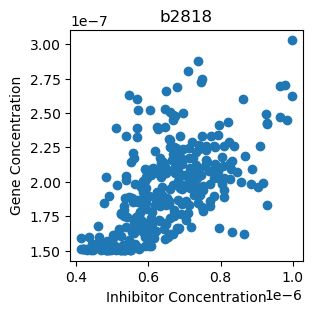

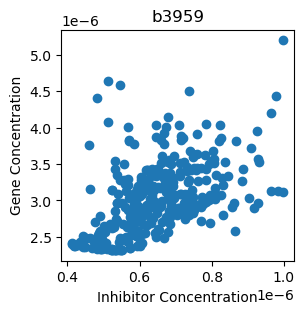

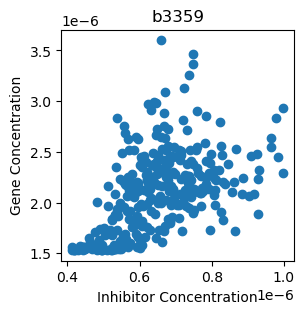

In [6]:
# plot TF concentration vs genes concentration
conc_df = pd.read_csv('../data/validation_data_sets/converted_log_tpm_in_M.csv', index_col = 0)
for gene in genes:
    fig = plt.figure(figsize = (3, 3))
    plt.scatter(conc_df.loc[inhibitor], conc_df.loc[gene])
    plt.xlabel('Inhibitor Concentration')
    plt.ylabel('Gene Concentration')
    plt.title(gene)
    plt.show()

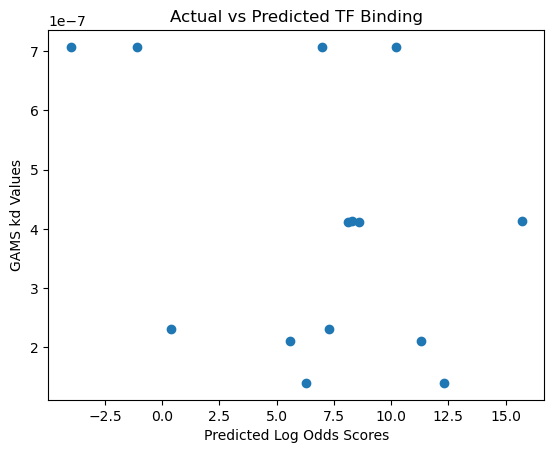

In [81]:
# compare log odds scores
log_odds = pd.read_pickle('../data/log_odds_binding.pkl')

log_odd_scores = []
kd_vals = []
for gene in cInh_kd_df.columns:
    if gene not in log_odds.index:
        continue
    for val in log_odds.loc[gene]['Score']:
        kd_vals.append(cInh_kd_df[gene].values[0])
        log_odd_scores.append(val)
plt.scatter(log_odd_scores, kd_vals)
plt.xlabel('Predicted Log Odds Scores')
plt.ylabel('GAMS kd Values')
plt.title('Actual vs Predicted TF Binding')
plt.show()

In [ ]:
# 3D plot of iModulons and mRNA ratios
# 3D plot their mRNA values along the phase planes
shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
    
    
#plt.rcParams["figure.dpi"] = 300
#matplotlib.rcParams['pdf.fonttype'] = 42
#sns.set_palette("deep")
#sns.set_context("paper")
#sns.set_style("whitegrid")

# data_complete is a pandas dataframe
# with the x, y, z values and color for each point as cols

for gene in genes:
    fig = plt.figure(figsize = (4, 4))
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    
    df_name = gene+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
    ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)

    ax.scatter(ratios_df.loc[shared]['MA_activator'], ratios_df.loc[shared]['MA_inhibitor'], ratios_df['actual_mRNA_ratio'].loc[shared], color = 'blue', label = 'actual')
    ax.scatter(ratios_df.loc[shared]['MA_activator'], ratios_df.loc[shared]['MA_inhibitor'], recon_df[shared].loc[gene], color = 'red', label = 'predicted')

    ax.set_xlabel('Activator iM Activity')
    ax.set_ylabel('Inhibitor iM Activity')
    ax.set_zlabel('mRNA Ratio')
    plt.legend()

    # this function defines the animation action done to the plot
    def rotate(angle):
         ax.view_init(azim=angle)

    angle = 3
    ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
    ani.save('../figures/'+gene+'.gif', writer=animation.PillowWriter(fps=10))

In [139]:
# print objective values
'''
total_obj .. total_diff =e= weight_obj1 * diff1 + weight_obj2 * diff2;
obj1 .. diff1 =e= sum((gene, sample), abs(10**TF_conc(sample) / 10**Kd(gene) - cEff(sample, gene)));
obj2 .. diff2 =e= sum(sample, abs(10**(meas_TF(sample)) - 0.1*10**TF_conc(sample))**2);
* ^ I found one paper that said about 10% of crp is active based on cAMP presence, this should be changed later though
'''
obj1 = 0
obj2 = 0
obj3 = 0
corr_obj = np.corrcoef(actual_TF_conc_df.loc[cAct_TF_conc_df.columns].values.flatten(), cAct_TF_conc_df.T.values.flatten())[0][1]
actual_TF_conc_df = pd.read_csv('../data/save_for_GAMs/exported_act_TF_conc.csv', index_col = 0)
for sample in cAct_TF_conc_df.columns:
    obj2 += (actual_TF_conc_df.loc[sample].values[0] - 0.1 * cAct_TF_conc_df[sample].values[0])**2
    for gene in kd_df.columns:
        df_name = gene+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
        ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)

        obj1 += abs((TF_conc_df[sample] / cAct_kd_df[gene] - saved_cActivators.loc[sample][gene])).values[0]
                
        obj3 += abs(ratios_df.loc[sample]['actual_mRNA_ratio'] - recon_df.loc[gene][sample])
print('Obj1 = '+str(obj1))
print('Obj2 = '+str(obj2))
print('Obj3 = '+str(obj3))
print('corr_obj = '+str(corr_obj))

# scale all to obj1
print('Scale obj2 by '+str(obj1 / obj2))
print('Scale obj3 by '+str(obj1 / obj3))
print('Scale corr_obj by '+str(obj1 / corr_obj))

Obj1 = 35873.818342515064
Obj2 = 0.0038071267507934245
Obj3 = 592.2935735168704
corr_obj = -0.33858011223456086
Scale obj2 by 9422806.40775587
Scale obj3 by 60.56763055777653
Scale corr_obj by -105953.70798879785


# validation attempts

## Amy's stationary phase data

In [6]:
# load in relevant data
starve_metabs = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_metabolites_data.csv', index_col = 0)
# above is in (µM) , convert to M
starve_metabs[starve_metabs.columns[1:]] *= 1e-6
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
starve_cols = list(set(starve_log_tpm.columns).intersection(actual_df.columns))

# setup
run_vals = [int(f.split('_')[1]) for f in os.listdir('../GAMs/runs/') if 'run_' in f]
GAMs_run_dir = '../GAMs/runs/run_'+str(max(run_vals))
calc_cAct, cAct_kd_df, cAct_TF_conc_df, calc_cInh, cInh_kd_df, cInh_TF_conc_df = iG.read_GAMs(GAMs_run_dir)


<IPython.core.display.Javascript object>


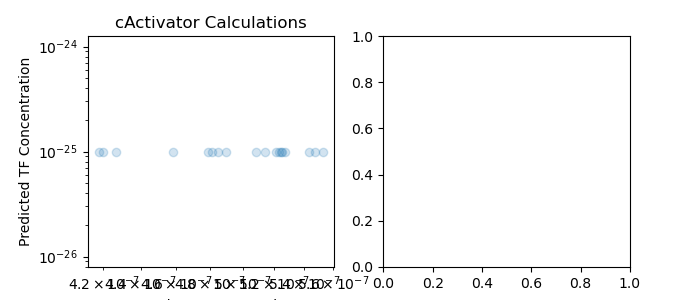

<IPython.core.display.Javascript object>


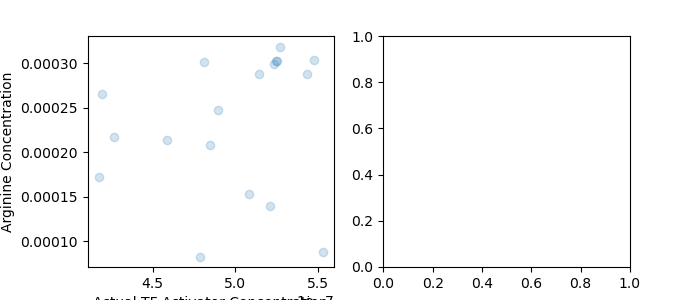

<IPython.core.display.Javascript object>


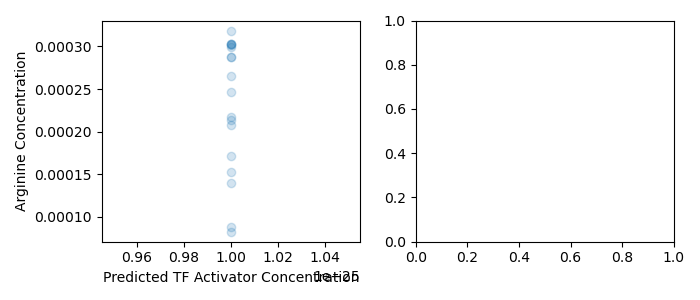

<IPython.core.display.Javascript object>


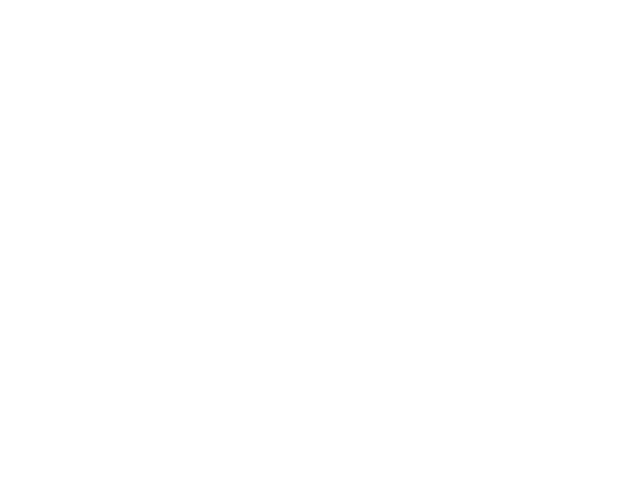

<IPython.core.display.Javascript object>


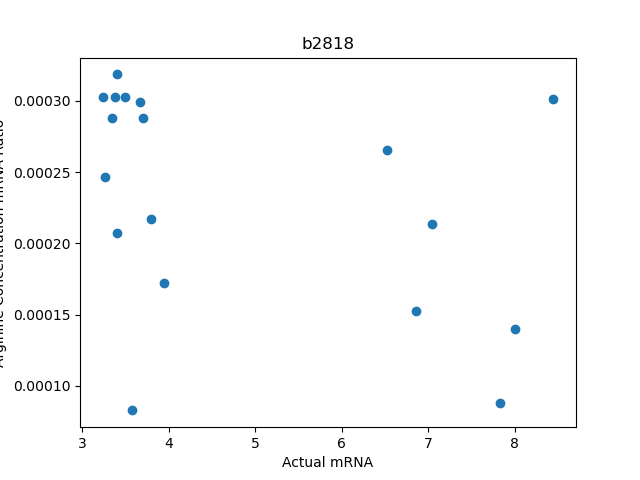

<IPython.core.display.Javascript object>


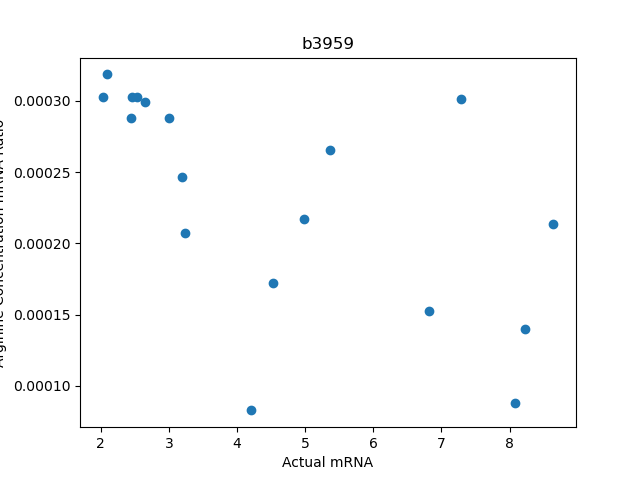

<IPython.core.display.Javascript object>


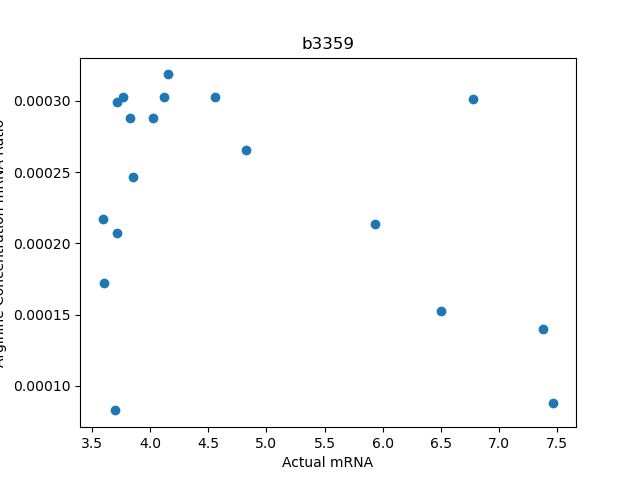

In [10]:
# plotting
# convert from cInh_kd_df and cInh_TF_conc_df to arginine


# how accurate is the model for these samples?
if False: # not super helpful to print every time
    plt.figure()
    for g in actual_df.index:
        plt.scatter(actual_df.loc[g][starve_cols], recon_df.loc[g][starve_cols], label = g)
    plt.xlabel('Actual mRNA Ratio')
    plt.ylabel('Reconstructed mRNA Ratio')
    plt.title('Stationary Phase Samples')
    plt.plot([0, max(actual_df.loc[g].values.flatten())], [0, max(actual_df.loc[g].values.flatten())], ls = '--', c = 'k')
    plt.legend()
    plt.show()

# how about the TF conc
# TF conc values
# histogram of TF_conc values
actual_TF_conc_df = pd.read_csv(GAMs_run_dir+'/input_files/exported_act_TF_conc.csv', index_col = 0)
TF_conc_df = 10**pd.read_csv(GAMs_run_dir+'/output_files/cAct_TF_conc_results.csv', index_col = 0).astype(float).T
fig, axs = plt.subplots(1, 2, figsize = (7, 3))
axs[0].scatter(actual_TF_conc_df.loc[starve_cols], TF_conc_df.T.loc[starve_cols], alpha = 0.2)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('Actual TF Concentration')
axs[0].set_ylabel('Predicted TF Concentration')
axs[0].set_title('cActivator Calculations')

try:
    actual_TF_conc_df = pd.read_csv(GAMs_run_dir+'/input_files/exported_inh_TF_conc.csv', index_col = 0)
    TF_conc_df = 10**pd.read_csv(GAMs_run_dir+'/output_files/cInh_TF_conc_results.csv', index_col = 0).astype(float).T
    axs[1].scatter(actual_TF_conc_df.loc[starve_cols], TF_conc_df.T.loc[starve_cols], alpha = 0.2)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Actual TF Concentration')
    axs[1].set_ylabel('Predicted TF Concentration')
    axs[1].set_title('cInhibitor Calculations')
    plt.tight_layout()
    plt.show()
except:
    pass


# now plot against cAMP concentration
# how about the TF conc
# TF conc values
# histogram of TF_conc values
actual_TF_conc_df = pd.read_csv(GAMs_run_dir+'/input_files/exported_act_TF_conc.csv', index_col = 0)
TF_conc_df = 10**pd.read_csv(GAMs_run_dir+'/output_files/cAct_TF_conc_results.csv', index_col = 0).astype(float).T
fig, axs = plt.subplots(1, 2, figsize = (7, 3))
axs[0].scatter(actual_TF_conc_df.loc[starve_cols], starve_metabs.loc['Arginine'][starve_cols], alpha = 0.2)
axs[0].set_xlabel('Actual TF Activator Concentration')
axs[0].set_ylabel('Arginine Concentration')

try:
    actual_TF_conc_df = pd.read_csv(GAMs_run_dir+'/input_files/exported_inh_TF_conc.csv', index_col = 0)
    TF_conc_df = 10**pd.read_csv(GAMs_run_dir+'/output_files/cInh_TF_conc_results.csv', index_col = 0).astype(float).T
    axs[1].scatter(actual_TF_conc_df.loc[starve_cols], starve_metabs.loc['Arginine'][starve_cols], alpha = 0.2)
    axs[1].set_xlabel('Actual TF Inhibitor Concentration')
    axs[1].set_ylabel('Arginine Concentration')
    plt.tight_layout()
    plt.show()
except:
    pass

fig, axs = plt.subplots(1, 2, figsize = (7, 3))
TF_conc_df = 10**pd.read_csv(GAMs_run_dir+'/output_files/cAct_TF_conc_results.csv', index_col = 0).astype(float).T
axs[0].scatter(TF_conc_df[starve_cols], starve_metabs.loc['Arginine'][starve_cols], alpha = 0.2)
axs[0].set_xlabel('Predicted TF Activator Concentration')
axs[0].set_ylabel('Arginine Concentration')
plt.tight_layout()

try:
    TF_conc_df = 10**pd.read_csv(GAMs_run_dir+'/output_files/cInh_TF_conc_results.csv', index_col = 0).astype(float).T
    axs[1].scatter(TF_conc_df[starve_cols], starve_metabs.loc['Arginine'][starve_cols], alpha = 0.2)
    axs[1].set_xlabel('Predicted TF Inhibitor Concentration')
    axs[1].set_ylabel('Arginine Concentration')
    plt.tight_layout()
    plt.show()
except:
    pass
# show each gene against arginine
plt.figure()
for g in actual_df.index:
    plt.figure()
    plt.scatter(starve_log_tpm.loc[g][starve_cols], starve_metabs.loc['Arginine'][starve_cols], label = g)
    plt.xlabel('Actual mRNA')
    plt.ylabel('Arginine Concentration mRNA Ratio')
    plt.title(g)
    plt.show()

# now just for ptsG
#plt.figure(figsize = (3, 3))
#plt.scatter(ratios_df['b1101'].loc[starve_cols], starve_metabs.loc['cAMP'][starve_cols], alpha = 0.2)
#plt.xlabel('PtsG mRNA Ratio')
#plt.ylabel('cAMP Concentration')
#plt.tight_layout()
#plt.show()

In [9]:
## TODO - need to check if all these units match, starve_metabls is in molarity, but is everything else?

<IPython.core.display.Javascript object>


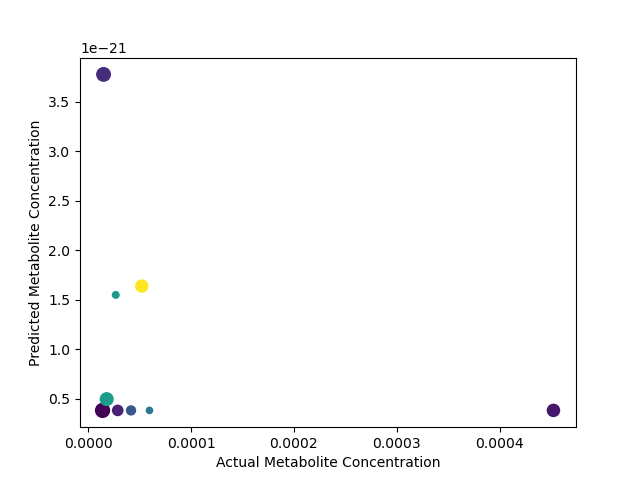

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

In [7]:
# conversion to metabolite total concentration
fed = ['starve_series__t00_growth1',
    'starve_series__t01_starve',
    'starve_series__t22_growth2',
    'starve_series__t23_growth2',
    'starve_series__t27_growth2',
    'starve_series__t28_growth2',]
starved = [#'starve_series__t02_starve',
 'starve_series__t03_starve',
 'starve_series__t06_starve',
# 'starve_series__t07_starve',
 'starve_series__t08_starve',
 'starve_series__t09_starve',
 'starve_series__t10_starve',
# 'starve_series__t11_starve',
# 'starve_series__t12_starve',
 'starve_series__t14_starve',
 'starve_series__t16_starve',
 'starve_series__t17_starve',
 'starve_series__t18_starve',]


%matplotlib notebook
times = 't0_1	t1_1	t2_1	t3_1	t4_1	t5_1	t6_1	t7_1	t8_1	t9_1	t10_1	t11_1	t12_1	t13_1	t14_1	t15_1	t16_1	t17_1	t18_1	t19_1	t20_1	t21_1	t22_1	t23_1	t24_1	t25_1	t26_1	t27_1	t28_1	t29_1	t30_1	t31_1	t32_1	t33_1	t34_1'
hours = '5.65	6.07	6.15	6.38	6.48	6.73	6.98	7.23	7.48	7.73	7.98	8.48	8.98	9.48	9.98	10.48	10.98	11.98	12.98	13.98	14.98	15.98	16.98	17.98	18.18	18.28	18.42	18.58	18.83	19.08	19.33	19.58	20.08	20.58	21.08'
time_to_hours = {k.split('_')[0] : float(v) for k, v in zip(times.split('\t'), hours.split('\t'))}

# settings
gene = 'b3255'
metabolite = 'AcetylN/ACoA' # Arginine, AcetylN/ACoA
color_by = 'rsd' # time, rsd
min_size = 20
max_size = 100
cols_use = starved # starved, fed, starve_cols (all)

if not promoter:
    pred_metab_df = cInh_TF_conc_df
else:
    pred_metab_df = cAct_TF_conc_df

rsd_df = pd.read_csv('../data/validation_data_sets/stationary_phase/rsd_df.csv', index_col = 0)
def map_value_to_color(value, vmin, vmax, colormap_name):
    # Normalize the value to be between 0 and 1
    normalized_value = (value - vmin) / (vmax - vmin)
    
    # Ensure the normalized value is within the [0, 1] range
    normalized_value = np.clip(normalized_value, 0, 1)
    
    # Get the colormap
    colormap = plt.get_cmap(colormap_name)
    
    # Map the normalized value to a color from the colormap
    color = colormap(normalized_value)
    
    # Convert the RGBA color to a hex representation
    hex_color = "#{:02x}{:02x}{:02x}".format(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))
    
    return hex_color
if color_by == 'time':
    min_t = min(time_to_hours.values())
    max_t = max(time_to_hours.values())
elif color_by == 'rsd':
    min_t = min(rsd_df[cols_use].loc[metabolite])
    max_t = max(rsd_df[cols_use].loc[metabolite])

min_exp = min(starve_log_tpm.loc[gene][cols_use])
max_exp = max(starve_log_tpm.loc[gene][cols_use])



fig, ax = plt.subplots()
labels = []
colors = []
sizes = []
for col in cols_use:
    size_pct = (starve_log_tpm.loc[gene][col] - min_exp) / (max_exp - min_exp)
    size = size_pct * (max_size - min_size) + min_size
    if color_by == 'time':
        val = time_to_hours['t'+str(int(col.split('__t')[1].split('_')[0]))]
    elif color_by == 'rsd':
        val = rsd_df[col].loc[metabolite]
    color = map_value_to_color(val, min_t, max_t, 'viridis')
    colors.append(color)
    sizes.append(size)
    labels.append(col)
scatter = ax.scatter(starve_metabs.loc[metabolite][cols_use], pred_metab_df[cols_use], s = sizes, c = colors)
mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(labels[sel.target.index]))
ax.set_ylabel('Predicted Metabolite Concentration')
ax.set_xlabel('Actual Metabolite Concentration')

# Create a ScalarMappable object for the color mapping
norm = Normalize(vmin=min_t, vmax=max_t)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Fake a normalization array

# Add colorbar
if color_by == 'time':
    cbar = plt.colorbar(sm, label='Time (hours)')
else:
    cbar = plt.colorbar(sm, label='Relative Std Dev of Metabolite Msmts')
    
plt.show()

if False: # 3D plot isn't too helpful
    fig = plt.figure(figsize = (4, 4))
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)

    for col in starve_cols:
        color = map_value_to_color(int(col.split('__t')[1].split('_')[0]), 0, max_t, 'viridis')
        ax.scatter(cInh_TF_conc_df[col], starve_metabs.loc['Arginine'][col], starve_log_tpm[col].loc['b2818'], c = color)
    ax.set_xlabel('Predicted Metabolite Concentration')
    ax.set_ylabel('Actual Metabolite Concentration')
    ax.set_zlabel('Log TPM of '+gene)
    plt.title('Arginine Matching')
    plt.tight_layout()
    plt.show()

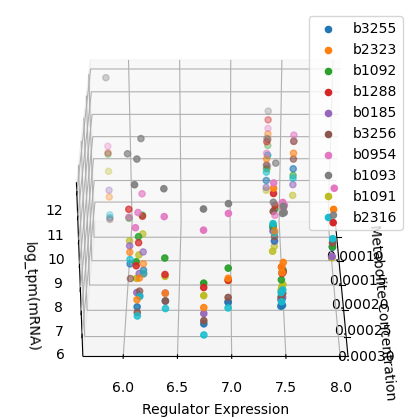

In [22]:
# checking for any type of trend in the data
#genes = ['b2818', 'b3959', 'b3958', 'b3359', 'b3957', 'b0273', 'b3172', 'b3960', 'b4254'] #'b1101', 'b1817', 'b1818', 'b1819', 
regulator = 'b1187' # b3237 is argR,  b1187 is fadR
# load in relevant data
starve_metabs = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_metabolites_data.csv', index_col = 0)
# above is in (µM) , convert to M
starve_metabs[starve_metabs.columns[1:]] *= 1e-6
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)

shared = list(set(ratios_df.index).intersection(set(starve_metabs.columns)))
for col in ['starve_series__t22_growth2__2', 'starve_series__t22_growth2__1', 'starve_series__t00_growth1__3']:
    pass#shared.remove(col)
# data_complete is a pandas dataframe
# with the x, y, z values and color for each point as cols
%matplotlib inline
fig = plt.figure(figsize = (4, 4))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
for gene in genes:

    df_name = gene+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
    ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)

    ax.scatter(starve_metabs[shared].loc['Arginine'], starve_log_tpm[shared].loc[regulator], starve_log_tpm[shared].loc[gene], label = gene)

ax.set_xlabel('Metabolite Concentration')
ax.set_ylabel('Regulator Expression')
ax.set_zlabel('log_tpm(mRNA)')
plt.tight_layout()
plt.legend()

# this function defines the animation action done to the plot
def rotate(angle):
     ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('../figures/combined_genes.gif', writer=animation.PillowWriter(fps=3))

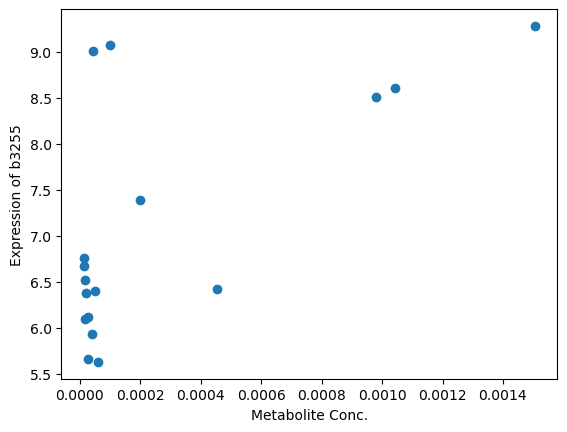

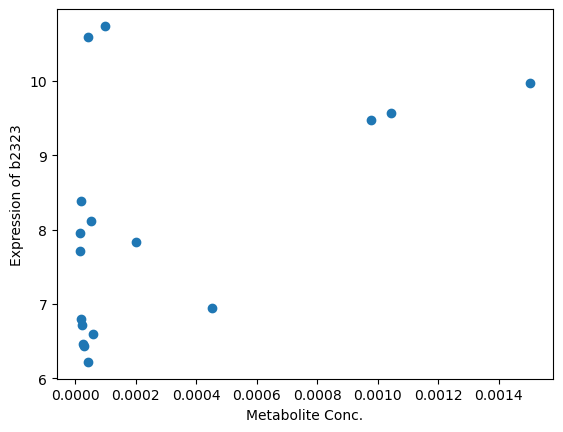

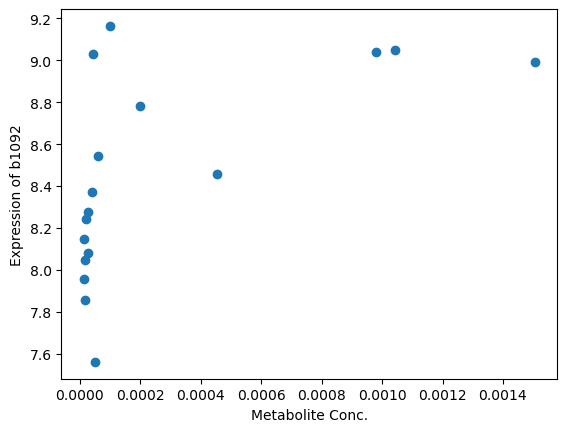

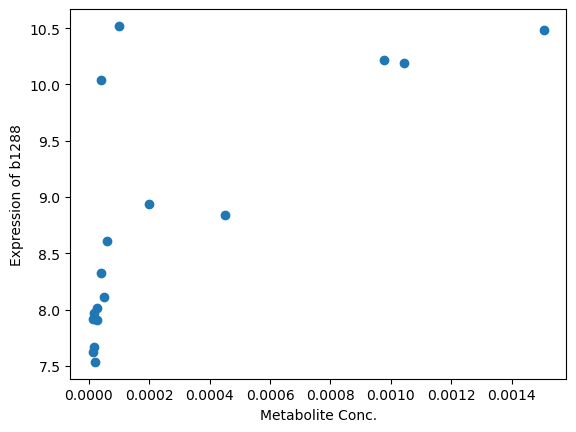

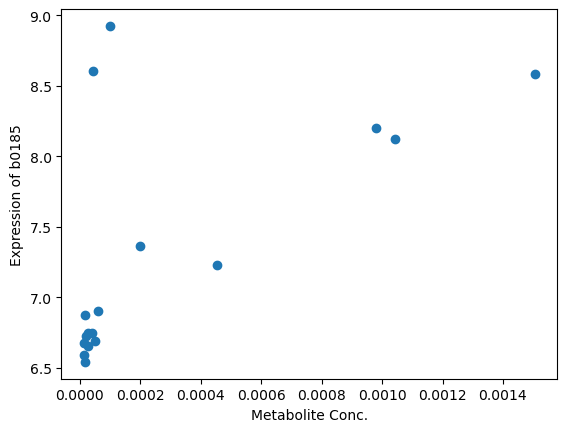

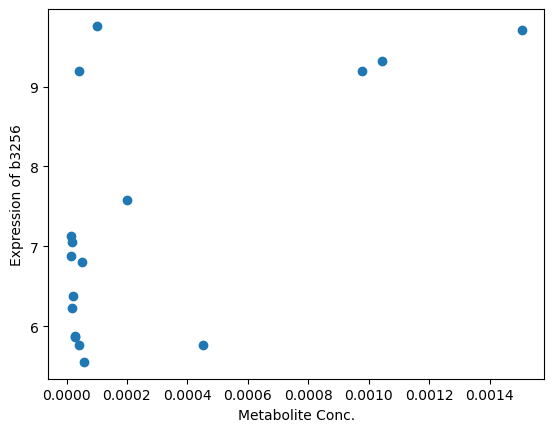

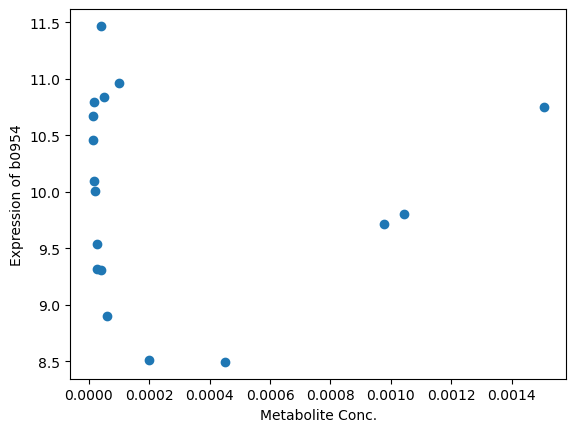

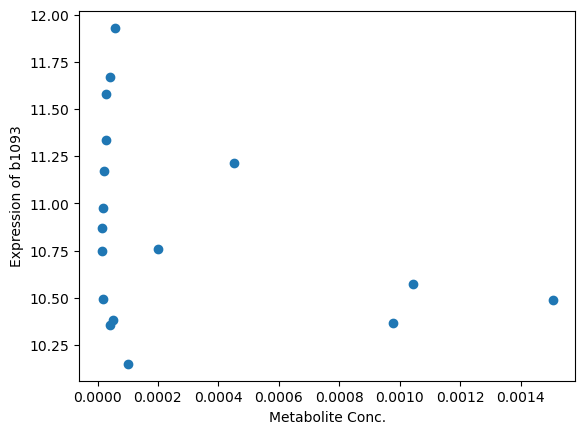

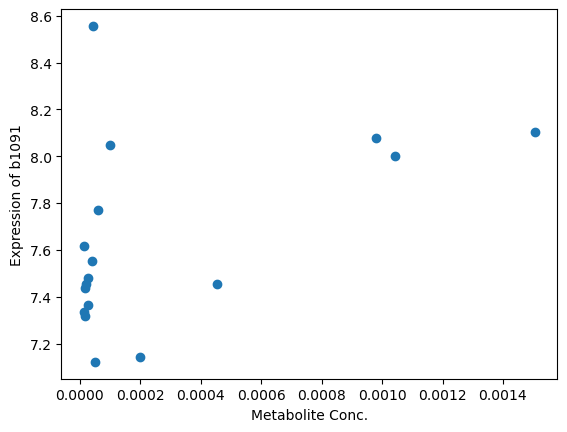

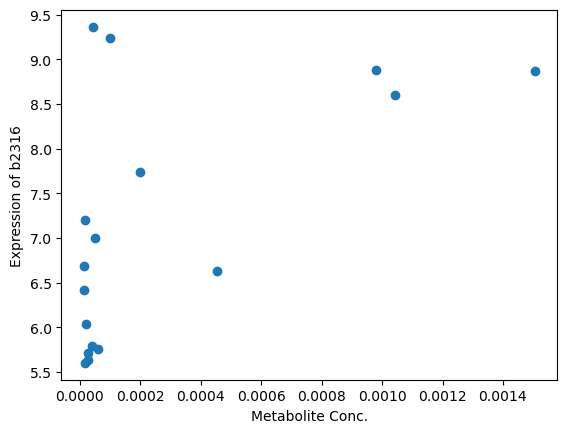

In [25]:
for gene in genes:
    plt.scatter(starve_metabs[shared].loc[metabolite], starve_log_tpm[shared].loc[gene])
    plt.xlabel('Metabolite Conc.')
    plt.ylabel('Expression of '+gene)
    plt.show()

## check unit accuracy

In [ ]:
# TODO - this

## model differences (investigation into why results here are different than gams_parameter_optimization)

In [14]:
# NOTES
# outputs are different, so it's not in the plotting
# input mRNA ratio and cInh values are the same
# grid constants are the same
# input_constants are the same
# sample_constants are the same
# parameters are different, first off one is missing some of the parameters of the others, let me standardize that
# fixed, code is rerunning some to regenerate "good" values to compare between single_click_run and gams_parameter_optimization
# I think this is all working now

single_dir = GAMs_run_dir
para_dir = '../GAMs/optimization_runs/argR_case/iter_2/run_234'

single_res = pd.read_csv(single_dir + '/input_files/parameters.csv', index_col = 0)
para_res = pd.read_csv(para_dir + '/input_files/parameters.csv', index_col = 0)

In [15]:
pd.concat([single_res, para_res], axis = 1)

,Value,Value
Parameter,,
act_TF_conc_lo,1.000000e-25,1.000000e-25
act_TF_conc_up,1.000000e-25,1.000000e-25
act_Kd_lo,2.142251e-04,1.000000e-06
act_Kd_up,2.142251e-04,1.050000e-04
inh_TF_conc_lo,2.902870e-15,1.000000e-10
inh_TF_conc_up,1.419066e-02,1.000000e-05
inh_Kd_lo,4.960298e-11,9.166667e-11
inh_Kd_up,2.142251e-04,1.050000e-04
weight_act_obj1,0.000000e+00,0.000000e+00


In [13]:
para_res

,Value
Parameter,
act_TF_conc_lo,1.000000e-25
act_TF_conc_up,1.000000e-25
act_Kd_lo,1.000000e-06
act_Kd_up,5.833333e-07
inh_TF_conc_lo,1.000000e-10
inh_TF_conc_up,1.000000e-05
inh_Kd_lo,1.833333e-11
inh_Kd_up,5.833333e-07
weight_act_obj1,0.000000e+00


# depreceated - creation of the pipeline (leave here for now)

In [10]:
# import statements
import os
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from IPython.display import display
import multiprocessing

import sys
sys.path.insert(0, '../functions/')
import basal_model_calcs as bmc
import mRNA_ratios as mr
import parameter_optimization as po
import create_cAct_cInh_vals as cv
import interface_GAMS as iG

In [2]:
# settings
flags = { # add additional settings that should be changed between runs here
    # general flags
    'force_rerun' : True,
    'sanity_plots' : True,
    'central_gene' : 'b1819',
    'basal_conditions' : ['control__wt_glc__1', 'control__wt_glc__2'],
    'grid_use' : -1, # which of the generated constants grids do you want to use? -1 is the highest KdRNAP
    
    # basal model flags
    'basal_bool': False, # If true, use imported values for basal expression

    # mRNA ratios flags
    'basal_or_hard_val' : 'basal', # use basal conditions for ratio or some hard value
    'hard_val' : 10, # the basal log tpm value
    'use_zerod_A_matrix' : True, # recalculate the ICA matrices based on zeroing out gene values in iModulons not of interest

    # picking KdRNAPCrp values
    'initial_guess_ratio' : .3, # this commonly needs to get raised and lowered to get a good value, eventually I will figure out a way to automate it if this step stays in the pipeline
    'base_cInhibitor_val' : 0.1, # this is the set minimum value to solve cActivator based on to set its dynamic range
    'base_cActivator_val' : 0.1, # defines the range of cInhibitor values available
    
    # cAct & cInh Grid flags
    'auto_set_max_range' : True, # if True, set the range based on the set to zero values of the KdRNAPCrp calculator
    'additional_tolerance' : 0.10, # add this %age of the maximum to the top
    'cActivator' : [-2,2], # Uses a log10 range
    'cInhibitor': [-2,2], # Uses a log10 range
    'run_greedy' : False, # skips greedy algo to save time

    # GA - best cActivator/cInhibitor flags
    'neg_grid_toss_OR_zero' : 'toss', # options: toss or zero, what to do with negative grid values
    'seed' : 42,
    'n_ind' : 100, # Starting population size
    'mu' : 100, # Number of individuals to select for the next generation
    'lambda_' : 100, # Number of offspring to produce
    'cxpb' : 0.6, # Chance of crossover
    'cx_prob' : 0.6, # Chance that a condition is crossed
    'mutpb' : 0.4, # Chance an individual undergoes mutation
    'mt_prob' : 0.1, # Chance that a condition in individual is mutated
    'n_gen' : 100, # Number of generations
    'verbose' : False, # Show the logbook as GA runs
    # NOTE: To modify the selection algorithm, modify the toolbox in the GA section of the notebook
    
    # greedy
    'n_iter' : 5, # Number of greedy individuals to produce, takes ~1 min for each
    'max_steps' : 30, # Maximum number of steps before moving on to next condition
    'n_rounds' : 100, # Number of loops of the shuffled conditions with the max steps for each greedy individual

    # GAMs
    'use_greedy' : False, # use the greedy algo values (if False, uses the results of the GA)
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : ['b1101', 'b1817', 'b1818', 'b1819'] # if run_on_all is False, limit to these samples (or which of them are available)
}


gene_to_act_inh_iMs = {
    'b1101' : ['Crp-2', 'DhaR/Mlc'],
    'b1817' : ['Crp-2', 'DhaR/Mlc'],
    'b1818' : ['Crp-2', 'DhaR/Mlc'],
    'b1819' : ['Crp-2', 'DhaR/Mlc'],
    'b2151' : ['Crp-1', 'Crp-2'],
    'b3601' : ['Crp-1', 'Crp-2'],
    'b2239' : ['Crp-2', 'GlpR'],
    'b2240' : ['Crp-2', 'GlpR'],
    'b0723' : ['Crp-2', 'ArcA-1'],
    'b1415' : ['Crp-2', 'Crp-1'],
    'b2597' : ['Crp-2', 'CpxR'],
    'b3403' : ['Crp-2', 'crp-KO'],
    'b4267' : ['Crp-2', 'GntR/TyrR'],
    'b2143' : ['Crp-2', 'YieP'],
}

# Grid constants, use these if basal_bool = False
# NOTE: The names of these variables must match the sympy equation
t_half_life_deg = 300
grid_constants = {
    'KdRNAP': 10**-5,
    'KdRNAPCrp': 2.5118864315095796e-07*1.4,
    #'KeqOpening': 10**-0.34444956947383365, gets set later
    'RNAP': 10**-6,
    'mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
    'k_d_TF': 1, # May change depending on model
    'kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'promoterConcVal': 10**-9, # Promoter concentration
    'TF': 0, # Concentration of TF
    'u': 1/3600, # Growth Rate
}

eq_str = 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))'

gene_grid_name = '../data/gene_grid_constants/'+flags['central_gene']+'.pkl'
if os.path.exists(gene_grid_name):
    pickle_in = open(gene_grid_name, 'rb')
    gene_grid_constants = pickle.load(pickle_in)
    pickle_in.close()
else:
    gene_grid_constants = {}
    
# Set reproducible random seed used by the GA
rng = np.random.default_rng(seed = flags['seed'])

# collect figures
gene_figs = []
together_figs = []

In [3]:
# to do
# 1 - add sanity plots, likely collected throughout
# 2 - better enforce flags['force_rerun'] to save runtime
# 3 - put "per every gene" functions into one function
# 4 - figure out scaled TF concentration

## per every gene

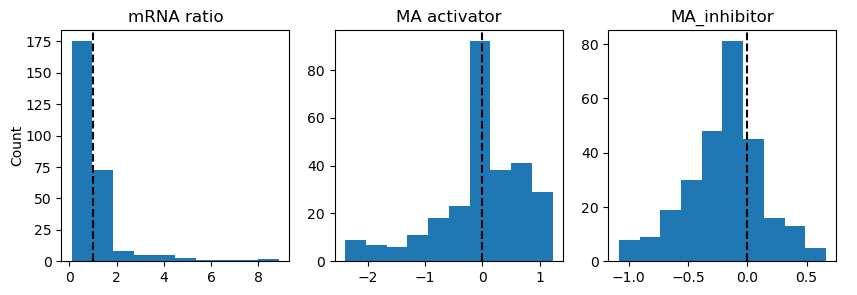

In [4]:
# create mRNA ratios and MA values
df_name = flags['central_gene']+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
if not flags['force_rerun'] and os.path.exists('../data/saved_mRNA_ratios_MA_vals/'+df_name):
    ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)
else:
    ratios_df = mr.calculate_mRNA_ratios_and_MA_values(gene_to_act_inh_iMs[flags['central_gene']][0], gene_to_act_inh_iMs[flags['central_gene']][1], flags)
    ratios_df.to_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name)
if flags['sanity_plots']:
    # sanity check plot
    fig, axs = plt.subplots(1, 3, figsize = (10, 3))
    axs[0].hist(ratios_df.actual_mRNA_ratio)
    axs[0].set_title('mRNA ratio')
    axs[0].axvline(x = 1, c = 'k', ls = '--')
    axs[1].hist(ratios_df.MA_activator)
    axs[1].set_title('MA activator')
    axs[1].axvline(x = 0, c = 'k', ls = '--')
    axs[2].hist(ratios_df.MA_inhibitor)
    axs[2].set_title('MA_inhibitor')
    axs[2].axvline(x = 0, c = 'k', ls = '--')
    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.ylabel('Count')
    gene_figs.append(fig)
    #plt.show()

In [5]:
# create TF concentration # TODO, CHECK THIS
log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
scaled_df = 2**log_tpm_df / (2**log_tpm_df).sum()

# save of TF concentrations of baseline values
# for now, it's just always crp
# goofy, scaling to same range/units as are used in GAMs
scaled_df.loc['b3357'].to_csv('../data/save_for_GAMs/exported_TF_conc.csv')

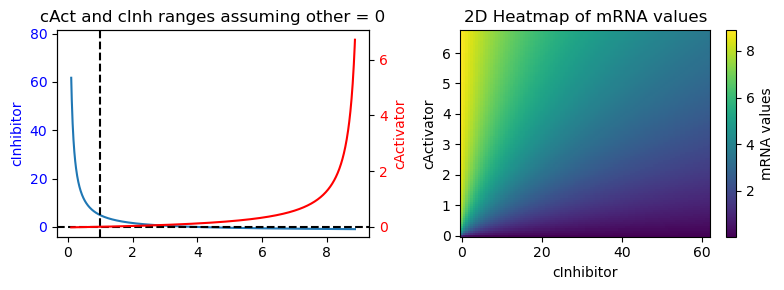

In [6]:
# pick KdRNAPCrp value, limit cActivator and cInhibitor based on it
# load in calculator
gene_grid_name = '../data/gene_grid_constants/'+flags['central_gene']+'.pkl'
if flags['force_rerun'] or not os.path.exists(gene_grid_name):  
    # basal model calculations
    grid_constants = bmc.basal_values(grid_constants, eq_str, flags)
    
    # pick KdRNAPCrp
    po.create_shared_lambda_df(eq_str, grid_constants)
    grid_constants['KdRNAPCrp'] = po.pick_KdRNAPCrp(ratios_df, flags)

    # save off grid constants
    pickle_out = open(gene_grid_name, 'wb')
    pickle.dump(grid_constants, pickle_out)
    pickle_out.close()
else:
    pickle_in = open(gene_grid_name, 'rb')
    grid_constants = pickle.load(gene_grid_name)
    pickle_in.close()
if flags['sanity_plots']:
    # sanity check plot

    # if you get weird results here, look at egulonML/parameter_optimization/0_framework.ipynb
    # it does the same thing as the function with plots along the way
    # try adjusting the initial guess for the first optimization
    # that is line 74 of functions/parameter_optimization.py

    # however, it is a sanity check to see if these values are near-correct
    rat_vals = np.linspace(min(ratios_df['actual_mRNA_ratio'].values.flatten()), max(ratios_df['actual_mRNA_ratio'].values.flatten()), 1000)

    cInh_vals = [po.mRNA_cActivator_to_cInhibitor(rat_val, flags['base_cActivator_val'], grid_constants['KdRNAPCrp']) for rat_val in rat_vals]
    cAct_vals = [po.mRNA_cInhibitor_to_cActivator(rat_val, flags['base_cInhibitor_val'], grid_constants['KdRNAPCrp']) for rat_val in rat_vals]

    fig, axs = plt.subplots(1, 2, figsize = (8, 3))
    ax1 = axs[0]
    l1, = ax1.plot(rat_vals, cInh_vals)
    plt.xlabel('mRNA Ratio')
    ax1.set_ylabel('cInhibitor', color = 'blue')
    ax1.tick_params(axis = 'y', labelcolor = 'blue')
    ax2 = ax1.twinx()
    l2, = ax2.plot(rat_vals, cAct_vals, color = 'red')
    ax2.set_ylabel('cActivator', color = 'red')
    ax2.tick_params(axis = 'y', labelcolor = 'red')
    ax1.axhline(y = 0, ls = '--', c = 'k')
    ax1.axvline(x = 1, ls = '--', c = 'k')
    # let's rescale cInhibitor (ax1) so that 0 is at the same point
    m1, M1 = ax1.get_ylim()
    percent1_up = (0 - m1) / (M1 - m1)
    m2, M2 = ax2.get_ylim()
    percent2_up = (0 - m2) / (M2 - m2)

    if percent1_up < percent2_up:
        # zero is higher than it should, so adjust it down by lowering the min
        m1 = percent2_up * M1 / (percent2_up - 1)
        ax1.set_ylim(m1, M1)
    else:
        # zero is lower than it should, so adjust it up
        M1 = m1 - (m1 / percent2_up)
        ax1.set_ylim(m1, M1)

    ax1.set_title('cAct and cInh ranges assuming other = 0')

    if flags['auto_set_max_range']:
        flags['cActivator'] = [-2, math.log10((1+flags['additional_tolerance'])*max(cAct_vals))] # Uses a log10 range
        flags['cInhibitor'] = [-2, math.log10((1+flags['additional_tolerance'])*max(cInh_vals))] # Uses a log10 range

    # let's create a 2D heatmap version of this, colored by the mRNA ratio
    cInh_range = np.linspace(0, max(cInh_vals), 100)
    cAct_range = np.linspace(0, max(cAct_vals), 100)
    mRNA_vals = pd.DataFrame(index = cInh_range, columns = cAct_range)
    for cInh in mRNA_vals.index:
        for cAct in mRNA_vals.columns:
            mRNA_vals.loc[cInh][cAct] = po.cActivator_cInhibitor_to_mRNA(cAct, cInh, grid_constants['KdRNAPCrp'])
    mRNA_vals = mRNA_vals.T.astype(float)

    # Convert the cInh_range and cAct_range to meshgrids for plotting
    cInh, cAct = np.meshgrid(cInh_range, cAct_range)

    # Create the heatmap
    heatmap = axs[1].pcolormesh(cInh, cAct, mRNA_vals.values, shading='auto', cmap='viridis')
    plt.colorbar(heatmap, label='mRNA values')
    axs[1].set_xlabel('cInhibitor')
    axs[1].set_ylabel('cActivator')
    axs[1].set_title('2D Heatmap of mRNA values')
    plt.tight_layout()
    gene_figs.append(fig)

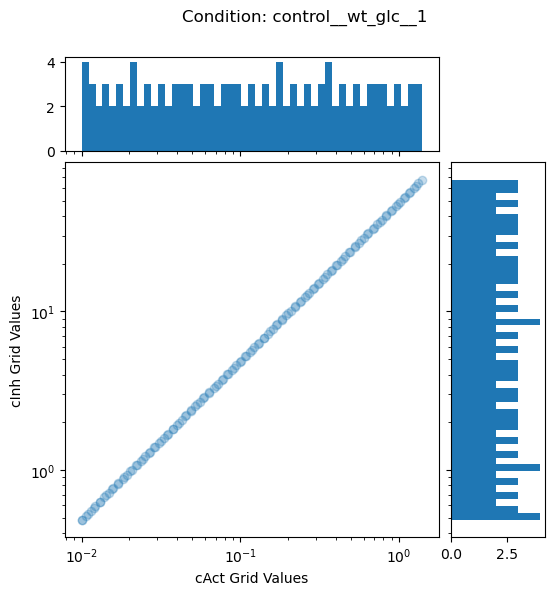

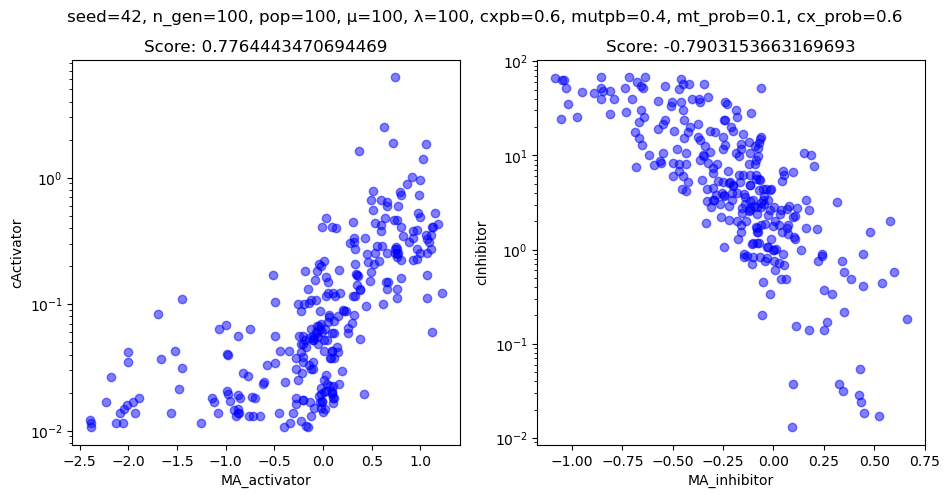

In [7]:
# determine cActivator and cInhibior values, and greedy
greedy_path = '../data/cAct_cInh_vals/'+flags['central_gene']+'_greedy.pkl'
norm_path = '../data/cAct_cInh_vals/'+flags['central_gene']+'.pkl'
if flags['force_rerun']:
    return_figs, greedy_cAct_cInh_df, cAct_cInh_df = cv.create_cAct_cInh_for_gene(ratios_df, grid_constants, eq_str, flags)
    if flags['run_greedy']:
        pickle_out = open(greedy_path, 'wb')
        pickle.dump(greedy_cAct_cInh_df, pickle_out)
        pickle_out.close()
        pickle_out = open(norm_path, 'wb')
        pickle.dump(cAct_cInh_df, pickle_out)
        pickle_out.close()
    else:
        pickle_out = open(norm_path, 'wb')
        pickle.dump(cAct_cInh_df, pickle_out)
        pickle_out.close()
else:
    if flags['run_greedy'] and os.path.exists(norm_path):
        pickle_in = open(norm_path, 'rb')
        cAct_cInh_df = pickle.load(pickle_in)
        pickle_in.close()
    elif os.path.exists(norm_path) and os.path.exists(greedy_path):
        pickle_in = open(norm_path, 'rb')
        cAct_cInh_df = pickle.load(pickle_in)
        pickle_in.close()
        pickle_in = open(greedy_path, 'rb')
        greedy_cAct_cInh_df = pickle.load(pickle_in)
        pickle_in.close()
    else: # need to rerun
        return_figs, greedy_cAct_cInh_df, cAct_cInh_df = cv.create_cAct_cInh_for_gene(ratios_df, grid_constants, eq_str, flags)
        if flags['run_greedy']:
            pickle_out = open(greedy_path, 'wb')
            pickle.dump(greedy_cAct_cInh_df, pickle_out)
            pickle_out.close()
            pickle_out = open(norm_path, 'wb')
            pickle.dump(cAct_cInh_df, pickle_out)
            pickle_out.close()
        else:
            pickle_out = open(norm_path, 'wb')
            pickle.dump(cAct_cInh_df, pickle_out)
            pickle_out.close()
for fig in return_figs:
    gene_figs.append(fig)

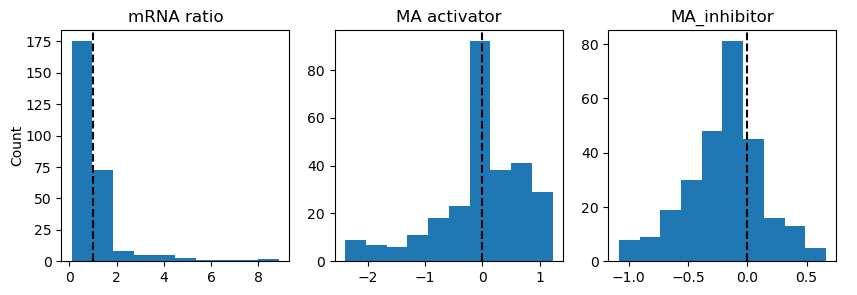

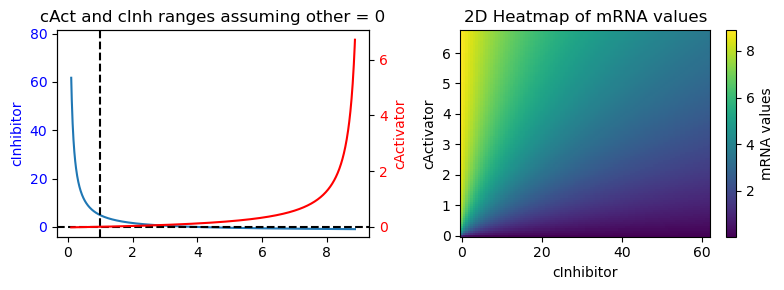

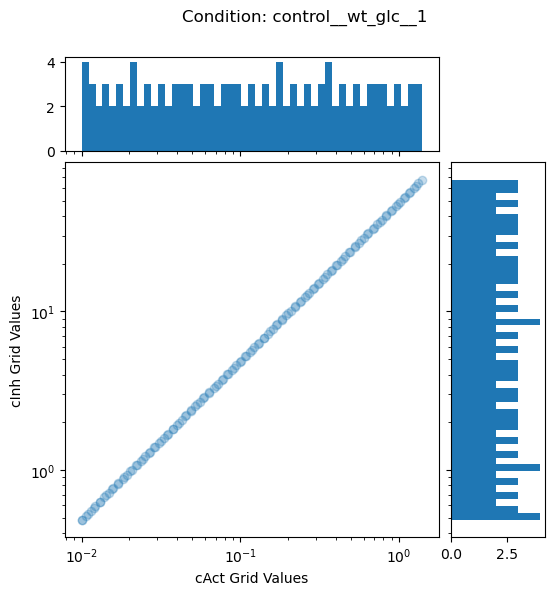

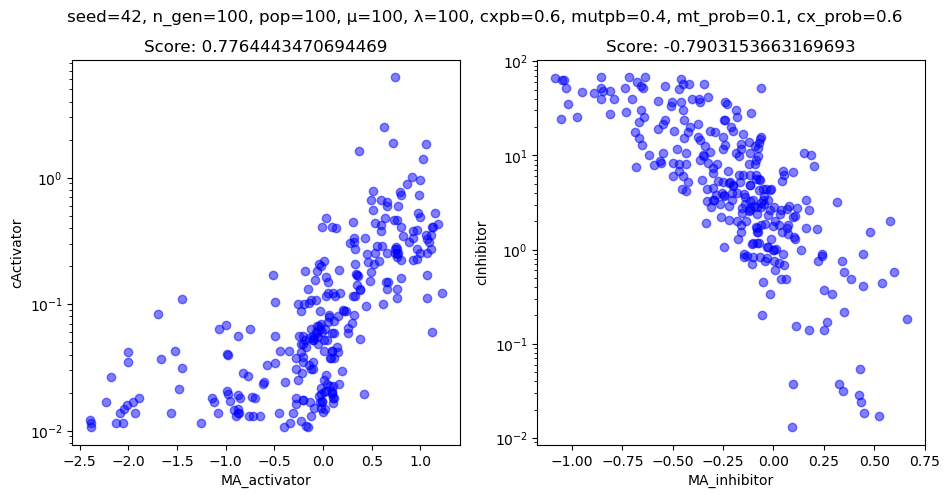

In [8]:
# show our gene_specific sanity plots
for fig in gene_figs:
    display(fig)

## don't do per gene

In [6]:
# run GAMs
if flags['force_rerun']:
    iG.run_GAMs(flags)

--- Job cAct_model Start 11/03/23 11:57:18 44.1.1 27c4d1f8 LEX-LEG x86 64bit/Linux
--- Applying:
    /opt/gams/gams44.1_linux_x64_64_sfx/gmsprmun.txt
--- GAMS Parameters defined
    Input /home/chris/github/regulonML/GAMs/cAct_model.gms
    ScrDir /home/chris/github/regulonML/GAMs/225a/
    SysDir /opt/gams/gams44.1_linux_x64_64_sfx/
Licensee: GAMS Demo, for EULA and demo limitations see   G230706/0001CB-GEN
          https://www.gams.com/latest/docs/UG%5FLicense.html         DC0000
          /opt/gams/gams44.1_linux_x64_64_sfx/gamslice.txt
          Demo license for demonstration and instructional purposes only
Processor information: 2 socket(s), 12 core(s), and 24 thread(s) available
GAMS 44.1.1   Copyright (C) 1987-2023 GAMS Development. All rights reserved
--- Starting compilation
--- cAct_model.gms(10) 2 Mb
--- call csv2gdx ../data/save_for_GAMs/composite_cAct_vals.csv id=cEff index=1 values=2..lastCol useHeader=y trace=0 output=./input_GDX/input.gdx
--- cAct_model.gms(11) 2 Mb
--

    461   4        2.7240493608E+02 9.9E-06   253 2.1E-04    2 F  T
    466   4        2.7240493608E+02 9.9E-06   252 8.3E-04    1 F  T
    471   4        2.7240493607E+02 9.7E-06   251 5.2E-01    1 F  T
    481   4        2.7240493605E+02 9.7E-06   250 9.4E+00    1 F  T
    491   4        2.7240493604E+02 9.7E-06   249 1.0E+00    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
    496   4        2.7240493603E+02 9.9E-06   249 9.9E-05    1 F  T
    501   4        2.7240493603E+02 9.7E-06   249 1.0E+00      F  T
    506   4        2.7240493603E+02 9.9E-06   249 7.3E-05    1 F  T
    511   4        2.7240493603E+02 9.9E-06   249 1.8E-05    1 F  T
    516   4        2.7240493602E+02 9.7E-06   249 1.0E+00    1 F  T
    521   4        2.7240493600E+02 9.7E-06   249 1.0E+00    1 F  T
    531   4        2.7240493592E+02 9.9E-06   249 5.3E-06      F  T
    536   4        2.7240493587E+02 9.9E-06   249 4.4E-04    1 F  T
    541   4        2.7240493587E+02 9.7E-06  

     81   4        2.9753577726E+02 6.8E-01   107 4.3E+00      F  T
     86   4        2.9701070257E+02 1.5E+00   106 1.0E+01    1 F  T
     91   4        2.9688536133E+02 6.3E-01   104 2.4E-02    1 F  T
    101   4        2.9562864096E+02 2.2E+00   124 5.1E-01      F  T
    106   4        2.9508489116E+02 8.0E-01   123 4.2E-02    1 F  T
    111   4        2.9489105321E+02 8.7E-01   123 1.0E+00    1 F  T
    116   4        2.9484054932E+02 1.9E-01   122 8.8E+00    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
    121   4        2.9482663275E+02 6.2E-01   121 1.0E+00    1 F  T
    126   4        2.9481534737E+02 1.9E-01   120 1.0E+00    1 F  T
    131   4        2.9377337356E+02 1.4E+00   139 1.0E+00      F  T
    141   4        2.9273125766E+02 1.1E+00   136 1.0E+01    1 F  T
    146   4        2.9265858379E+02 3.5E-01   135 1.8E+00    1 F  T
    151   4        2.9262161405E+02 7.4E-01   133 1.0E-02    1 F  T
    156   4        2.9261135576E+02 5.3E-01  

    751   4        2.8617128768E+02 1.2E+00   121 4.8E-06    1 F  T
    756   4        2.8617118139E+02 7.0E-01   121 1.9E+01    1 F  T
    761   4        2.8617055504E+02 8.2E-01   121 3.4E-05    1 F  T
    766   4        2.8617010236E+02 1.8E+00   121 1.3E-01    1 F  T
    771   4        2.8616955617E+02 1.5E+00   120 1.4E-02      F  T
    781   4        2.8616815359E+02 5.3E-01   119 6.9E-05    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
    786   4        2.8616760896E+02 2.9E+00   118 1.0E+00    1 F  T
    791   4        2.8615153617E+02 2.1E+00   125 4.1E+00    1 F  T
    796   4        2.8613266810E+02 8.9E-01   123 7.6E+00    1 F  T
    801   4        2.8604123566E+02 1.7E+00   122 1.8E-01      F  T
    811   4        2.8601272269E+02 7.9E-01   120 4.2E+00    1 F  T
    816   4        2.8600986677E+02 1.6E+00   119 1.0E+00    1 F  T
    821   4        2.8600794352E+02 7.6E-01   119 6.9E-01    1 F  T
    826   4        2.8600590993E+02 7.0E-01  

   1461   4        2.8493571698E+02 1.4E+00    78 6.4E-06    1 F  T
   1466   4        2.8493569491E+02 9.3E-01    77 3.3E+00    1 F  T
   1471   4        2.8493564765E+02 2.1E+00    77 4.5E-06    1 F  T
   1476   4        2.8493557340E+02 5.8E-01    77 1.0E+00    1 F  T
   1481   4        2.8493552500E+02 3.0E+00    77 6.2E-06    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   1486   4        2.8493544058E+02 7.3E-01    77 5.2E-06    1 F  T
   1491   4        2.8493541817E+02 3.6E+00    75 2.0E+01    1 F  T
   1496   4        2.8493538730E+02 1.5E+00    74 3.9E-06    1 F  T
   1501   4        2.8493530240E+02 4.7E+00    78 5.4E-04      F  T
   1511   4        2.8493527506E+02 4.2E+00    78 1.9E+02    1 F  T
   1516   4        2.8493524871E+02 9.8E-01    78 1.6E-05    1 F  T
   1521   4        2.8493523150E+02 6.1E-01    75 1.0E+00    1 F  T
   1531   4        2.8493519858E+02 8.5E-01    73 2.5E-01    1 F  T
   1536   4        2.8493518197E+02 1.1E+00  

   2186   4        2.8438260610E+02 9.2E-01    35 1.3E-07    1 F  T
   2191   4        2.8438260566E+02 1.8E+00    35 6.2E-06      F  T
   2201   4        2.8438260408E+02 9.2E-01    34 4.6E-01    1 F  T
   2206   4        2.8438260362E+02 1.5E+00    33 1.4E-08    1 F  T
   2211   4        2.8438260308E+02 2.4E+00    35 2.8E-08      F  T
   2221   4        2.8438260301E+02 2.4E+00    33 1.0E+00    1 F  T
   2231   4        2.8438260298E+02 1.4E+00    33 2.2E-10      F  T
   2236   4        2.8438260298E+02 2.9E+00    33 5.3E-10    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   2241   4        2.8438260295E+02 8.9E-01    34 1.0E-07      F  T
   2246   4        2.8438260295E+02 1.3E+00    33 4.6E-10    2 F  T
   2251   4        2.8438260293E+02 2.5E+00    33 1.0E+00    1 F  T
   2261   4        2.8438260275E+02 8.1E-01    32 9.4E-06      F  T
   2266   4        2.8438260255E+02 8.1E-01    31 9.4E-10    1 F  T
   2271   4        2.8438260246E+02 8.1E-01  

   2861   4        2.8380788409E+02 9.0E-01    31 1.0E+00    1 F  T
   2866   4        2.8380765051E+02 1.0E+00    31 3.4E-01    1 F  T
   2871   4        2.8380740994E+02 5.4E+00    31 5.5E-05    1 F  T
   2881   4        2.8380575326E+02 9.0E-01    30 4.1E-03      F  T
   2886   4        2.8380357400E+02 1.6E+00    29 1.0E-04    1 F  T
   2891   4        2.8379673050E+02 1.8E+00    29 1.2E-04    1 F  T
   2901   4        2.8379502505E+02 6.9E-01    29 2.7E-06      F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   2906   4        2.8379495559E+02 2.3E+00    28 4.4E+00    1 F  T
   2911   4        2.8379483650E+02 9.0E-01    26 2.4E+00    1 F  T
   2921   4        2.8378456914E+02 2.4E+00    31 2.5E-03    1 F  T
   2926   4        2.8378375628E+02 8.0E-01    29 3.3E+00    1 F  T
   2931   4        2.8378289984E+02 3.0E+00    28 6.3E-02      F  T
   2941   4        2.8378241716E+02 1.4E+00    27 1.0E-04    1 F  T
   2951   4        2.8378225832E+02 6.9E-01  

 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   3611   4        2.8325348363E+02 1.4E+00    38 1.4E+01    1 F  T
   3616   4        2.8319425254E+02 3.3E+00    37 1.1E-02    1 F  T
   3621   4        2.8310027638E+02 1.4E+00    36 1.0E+00    1 F  T
   3626   4        2.8303147467E+02 2.6E+00    37 5.3E-03    1 F  T
   3631   4        2.8301317861E+02 8.2E-01    35 1.0E+00    1 F  T
   3636   4        2.8300222337E+02 1.9E+00    36 4.1E-03    1 F  T
   3641   4        2.8297874207E+02 6.9E-01    33 3.0E-02    1 F  T
   3651   4        2.8293287112E+02 8.2E-01    31 5.0E-01      F  T
   3656   4        2.8291771216E+02 1.8E+00    34 7.2E+00    1 F  T
   3661   4        2.8289358429E+02 1.2E+00    33 1.3E-03    3 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   3671   4        2.8288637857E+02 1.7E+00    30 2.0E+00    1 F  T
   3676   4        2.8288436620E+02 1.3E+00    29 2.0E-04    1 F  T
   3681   4        2.8288382328E+02 1.3E+0

   4321   4        2.8274470564E+02 9.2E-01     8 3.4E-03      F  T
   4331   4        2.8274470440E+02 9.2E-01     8 1.6E-06    1 F  T
   4336   4        2.8274470377E+02 1.9E+00     7 3.3E-07    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   4341   4        2.8274470371E+02 9.2E-01     7 2.9E-11      F  T
   4346   4        2.8274470368E+02 9.6E-01     6 1.5E-08    1 F  T
   4351   4        2.8274470266E+02 8.1E-01     6 1.0E+00    1 F  T
   4361   4        2.8274470263E+02 6.1E-01     6 3.1E-07    1 F  T
   4366   4        2.8274470263E+02 6.1E-01     6 3.1E-07    1 F  T
   4371   4        2.8274469904E+02 1.2E+00    23 3.0E-05      F  T
   4381   4        2.8274292572E+02 1.0E+00    21 1.2E-04      F  T
   4391   4        2.8274254406E+02 1.4E+00    17 4.4E-04    1 F  T
   4401   4        2.8274186375E+02 1.6E+00    15 1.0E+00    1 F  T
   4411   4        2.8274169218E+02 4.8E+00    15 5.8E-06    1 F  T
 
   Iter Phase Ninf     Objective     RGmax 

   5066   4        2.8267906042E+02 9.2E-01    11 6.1E+00    1 F  T
   5071   4        2.8267904707E+02 9.9E-01    10 1.3E-01      F  T
   5076   4        2.8267904408E+02 8.2E-01    10 5.3E-01    1 F  T
   5081   4        2.8267904383E+02 2.6E+00    10 5.8E-08    1 F  T
   5086   4        2.8267904382E+02 1.4E+00     9 4.0E+00    1 F  T
   5091   4        2.8267904377E+02 7.7E-01     8 1.0E+00    1 F  T
   5096   4        2.8267904376E+02 1.1E+00    10 7.2E-09    1 F  T
 
   Iter Phase Ninf     Objective     RGmax    NSB   Step InItr MX OK
   5101   4        2.8267904373E+02 1.8E+00     9 6.4E-09    1 F  T
   5111   4        2.8267902268E+02 1.5E+00     8 1.0E+00    1 F  T
   5116   4        2.8267902207E+02 5.9E-01     8 1.5E-01    1 F  T
   5121   4        2.8267902206E+02 2.2E+00     8 9.5E-09    1 F  T
   5131   4        2.8267902203E+02 8.9E-01     7 1.9E-09    1 F  T
   5136   4        2.8267902203E+02 8.9E-01     5 3.6E-01    1 F  T
   5141   4        2.8267902203E+02 1.4E+00  

AttributeError: module 'interface_GAMS' has no attribute 'read_GAMs'

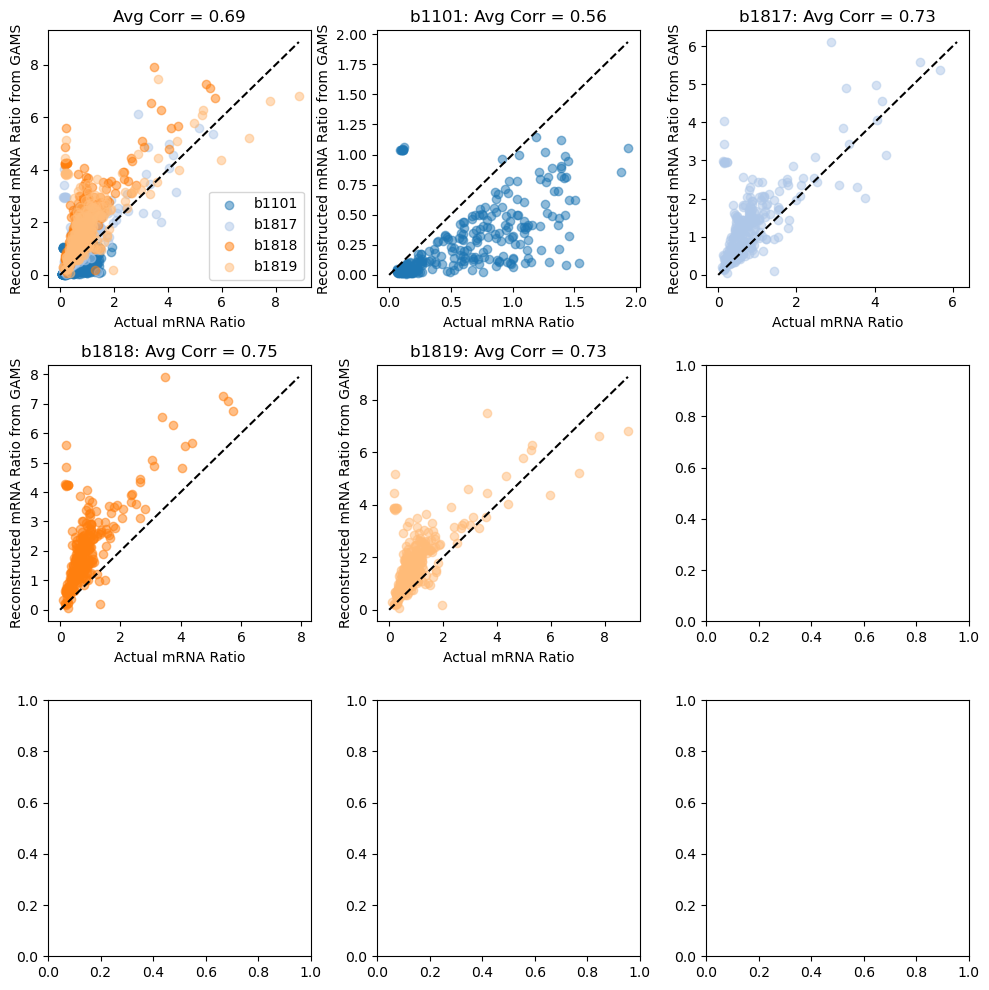

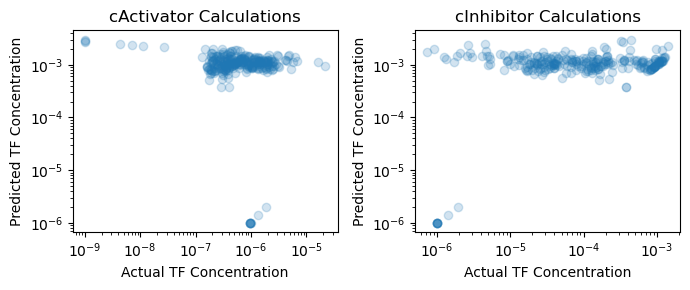

In [18]:
# read GAMs
calc_cAct, cAct_kd_df, cAct_TF_conc_df, calc_cInh, cInh_kd_df, cInh_TF_conc_df = iG.read_GAMs(flags)
if flags['sanity_plots']:
    
    # I need recreated cActivators and cInhibitors
    colors = iter(plt.cm.tab20.colors)
    shared = list(set(calc_cAct.index).intersection(set(calc_cInh.index)))
    corrs = []
    max_mRNA = 0
    dims = int(np.sqrt(len(calc_cAct.columns)))+1
    fig, axs = plt.subplots(dims, dims, figsize = (10, 10))
    axs = axs.flatten()
    #plt.figure(figsize = (4, 4))
    g_ct = 1
    for gene in calc_cAct.columns:
        # load grid constants
        gene_grid_name = '../data/gene_grid_constants/'+gene+'.pkl'
        pickle_in = open(gene_grid_name, 'rb')
        grid = pickle.load(pickle_in)
        pickle_in.close()

        df_name = gene+'_zerod'+str(flags['use_zerod_A_matrix'])+'_mRNA_ratios_and_MA_vals.csv'
        ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)

        recon_mRNA = []
        for cAct, cInh in zip(calc_cAct[gene].loc[shared], calc_cInh[gene].loc[shared]):
            recon_mRNA.append(po.cActivator_cInhibitor_to_mRNA(cAct, cInh, KdRNAPCrp = grid['KdRNAPCrp']))

        actual_mRNA = ratios_df.loc[shared]['actual_mRNA_ratio'].values.flatten()
        if max([max(actual_mRNA), max(recon_mRNA)]) > max_mRNA:
            max_mRNA = max([max(actual_mRNA), max(recon_mRNA)])
        max_bby_mRNA = max([max(actual_mRNA), max(recon_mRNA)])

        corr = np.corrcoef(list(actual_mRNA), list(recon_mRNA))
        corrs.append(corr[0][1])
        c = next(colors)
        axs[0].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
        axs[g_ct].scatter(actual_mRNA, recon_mRNA, label = gene, c = c, alpha = 0.5)
        axs[g_ct].plot([0, max_bby_mRNA], [0, max_bby_mRNA], ls = '--', c = 'k')
        axs[g_ct].set_title(gene+': Avg Corr = {:.2f}'.format(corr[0][1]))
        axs[g_ct].set_xlabel('Actual mRNA Ratio')
        axs[g_ct].set_ylabel('Reconstructed mRNA Ratio from GAMS')
        g_ct += 1


    axs[0].plot([0, max_mRNA], [0, max_mRNA], ls = '--', c = 'k')
    axs[0].legend()
    axs[0].set_title('Avg Corr = {:.2f}'.format(np.mean(corrs)))
    axs[0].set_xlabel('Actual mRNA Ratio')
    axs[0].set_ylabel('Reconstructed mRNA Ratio from GAMS')
    plt.tight_layout()
    together_figs.append(fig)
    
    
    
    # TF conc values
    # histogram of TF_conc values
    TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cAct_TF_conc_results.csv', index_col = 0).astype(float).T
    fig, axs = plt.subplots(1, 2, figsize = (7, 3))
    axs[0].scatter(TF_conc_df.T.loc[shared], scaled_df.loc['b3357'].T.loc[shared], alpha = 0.2)
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('Actual TF Concentration')
    axs[0].set_ylabel('Predicted TF Concentration')
    axs[0].set_title('cActivator Calculations')

    TF_conc_df = 10**pd.read_csv('../data/GAMS_output/cInh_TF_conc_results.csv', index_col = 0).astype(float).T
    axs[1].scatter(TF_conc_df.T.loc[shared], scaled_df.loc['b3357'].T.loc[shared], alpha = 0.2)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Actual TF Concentration')
    axs[1].set_ylabel('Predicted TF Concentration')
    axs[1].set_title('cInhibitor Calculations')
    plt.tight_layout()
    together_figs.append(fig)